# My Lane Detection Demo
@description: <br>
&nbsp;&nbsp;&nbsp;&nbsp; a simple Straight-lane detection using hough transform<br>
@auth: xrq<br>
@date: 2019-01

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import cv2

### Read and display test image 
Image directory: /home/xrq/lane_detection/Lane_detection/test_images/

shape of image (1080, 1920, 3)


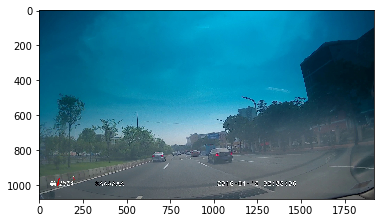

In [6]:
image = img.imread("real-test.jpg")
print("shape of image",image.shape)
plt.imshow(image)

### Processing Functions
Some transforms function definition:
- gray_scale
- gussian_blur
- canny
- ROI -- 65% of the height was selected
- hough transform
- high angle pass filter
- cv2.inRange() for color selection


In [7]:
 
def filter_colors(image):
    """
    Filter the image to include only yellow and white pixels
    """
    # Filter white pixels
    white_threshold = 180
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(image, lower_white, upper_white)
    white_image = cv2.bitwise_and(image, image, mask=white_mask)
    
    # Filter yellow pixels
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([90,100,100])
    upper_yellow = np.array([110,255,255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    yellow_image = cv2.bitwise_and(image, image, mask=yellow_mask)

    # Combine the two above images
    image2 = cv2.addWeighted(white_image, 1., yellow_image, 1., 0.)
    return white_image

def gray_scale(img):
    # change RGB image to gray image
    return cv2.cvtColor(img,cv2.COLOR_RGB2BGRA)

def gussian_blur(img,kernel_size):
    # gussian filter
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def canny(img,low_threshold,high_threshold):
    # edge detection
    return cv2.Canny(img,low_threshold,high_threshold)

def region_of_interest(img,vertices):
    #define a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape)>2:   # 3 channel
        channel_count = img.shape[2]
        ignore_mask_color = (255,)*channel_count
    else: 
        ignore_mask_color = 255  # black
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    masked_image = cv2.bitwise_and(img,mask) #pixel-wise AND operate
    return masked_image 

def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # In case of error, don't draw the line
    draw_right = True
    draw_left = True
    
    # Find slopes of all lines
    # But only care about lines where abs(slope) > slope_threshold
    slope_threshold = 0.25
    slopes = []
    new_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]  # line = [[x1, y1, x2, y2]]
        
        # Calculate slope
        if x2 - x1 == 0.:  # corner case, avoiding division by 0
            slope = 999.  # practically infinite slope
        else:
            slope = (y2 - y1) / (x2 - x1)
            
        # Filter lines based on slope
        if abs(slope) > slope_threshold:
            slopes.append(slope)
            new_lines.append(line)
        
    lines = new_lines
    
    # Split lines into right_lines and left_lines, representing the right and left lane lines
    # Right/left lane lines must have positive/negative slope, and be on the right/left half of the image
    right_lines = []
    left_lines = []
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        img_x_center = img.shape[1] / 2  # x coordinate of center of image
        if slopes[i] > 0 :
            right_lines.append(line)
        elif slopes[i] < 0 and x1 < img_x_center and x2 < img_x_center:
            left_lines.append(line)
            
    # Run linear regression to find best fit line for right and left lane lines
    # Right lane lines
    right_lines_x = []
    right_lines_y = []
    
    for line in right_lines:
        x1, y1, x2, y2 = line[0]
        
        right_lines_x.append(x1)
        right_lines_x.append(x2)
        
        right_lines_y.append(y1)
        right_lines_y.append(y2)
        
    if len(right_lines_x) > 0:
        right_m, right_b = np.polyfit(right_lines_x, right_lines_y, 1)  # y = m*x + b
        print("contain right lines: ",right_lines_x)
    else:
        right_m, right_b = 1, 1
        draw_right = False
        
    # Left lane lines
    left_lines_x = []
    left_lines_y = []
    
    for line in left_lines:
        x1, y1, x2, y2 = line[0]
        
        left_lines_x.append(x1)
        left_lines_x.append(x2)
        
        left_lines_y.append(y1)
        left_lines_y.append(y2)
        
    if len(left_lines_x) > 0:
        left_m, left_b = np.polyfit(left_lines_x, left_lines_y, 1)  # y = m*x + b
        print("contain left lines: ",left_lines_x)
    else:
        left_m, left_b = 1, 1
        draw_left = False
    
    # Find 2 end points for right and left lines, used for drawing the line
    # y = m*x + b --> x = (y - b)/m
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.8
    
    right_x1 = (y1 - right_b) / right_m
    right_x2 = (y2 - right_b) / right_m
    
    left_x1 = (y1 - left_b) / left_m
    left_x2 = (y2 - left_b) / left_m
    
    # Convert calculated end points from float to int
    y1 = int(y1)
    y2 = int(y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
    
    # Draw the right and left lines on image
    if draw_right:
        cv2.line(img, (right_x1, y1), (right_x2, y2), color, thickness)
    if draw_left:
        cv2.line(img, (left_x1, y1), (left_x2, y2), color, thickness)
        

def hough_lines(img,rho,theta,threshold,min_line_len,max_line_gap):
    # hough transform to detect lines
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap = max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)  # 3-channel RGB image
    '''
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img,(x1,y1),(x2,y2),color=[255,0,0],thickness=2)
     '''
    draw_lines(line_img, lines)
    return line_img

            
def hpass_angle_filter(lines,angle_threshold):
    # high pass angle filter
    if lines.shape!=None:
        filtered_lines =[]
        for line in lines:
            for x1,y1,x2,y2 in line:
                angle = abs(np.arctan((y2-y1)/(x2-x1))*180/np.pi)
                if angle > angle_threshold:
                    filtered_lines.append([[x1,y1,x2,y2]])
        return filtered_lines
    
  
    
            
def show_img(ax,img,cmap,title):
    if cmap=='gray':
        ax.imshow(img,cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)
    
def weighted_img(img,initial_img,a=0.8,b=1,r=0.0):
    # add the orignal image and line mask together
    return cv2.addWeighted(initial_img,a,img,b,r)



def pipeline(image):
    two_color_image = filter_colors(image)
    gray_img = gray_scale(two_color_image)  # gray scale image
    gussian_img = gussian_blur(gray_img,3)  # gussian filter
    canny_img = canny(gussian_img,10,150)   # edge detection
    # draw the ROI mask
    imshape = image.shape
    point1 = (700,imshape[0]*0.8)  # shape[0] denote width
    point2 = (1000,imshape[0]*0.8)
    point3 = (520,970)
    point4 = (1375,970)  # shape[1] denote height
    vertices = np.array([[point1,point2,point4,point3]],dtype=np.int32)
    roi_img = region_of_interest(canny_img,vertices)
    # *** finfinshed  **** 
    threshold_angle = 20
    # hough line detection and line filter
    hlines_img = hough_lines(roi_img,rho=1,theta=np.pi/180,threshold=25,min_line_len=10,max_line_gap=10)
    #h_lines = hpass_angle_filter(h_lines,threshold_angle) 
    #print ("lines after angle filter",h_lines)
    # draw empty line mask
    
    img_all_lines = weighted_img(hlines_img,image,a=0.7,b=1,r=0.0) # line mask + original image
    # plot image of each process
    
    '''
    _,ax = plt.subplots(2,4,figsize=(20,10))
    
    show_img(ax[0,0],two_color_image,'color mask','Apply color filter')
    show_img(ax[0,1],image,None,'original_img')
    show_img(ax[0,2],gray_img,'gray','Apply grayscale')
    show_img(ax[0,3],gussian_img,'gray','Apply Gaussian Blur')
    show_img(ax[1,0],canny_img,'gray','Apply Canny')
    show_img(ax[1,1],roi_img,'gray','Apply ROI mask')
    show_img(ax[1,2],hlines_img,None,'Apply Hough')
    plt.show()
    # The final result
    plt.imshow(img_all_lines)
    '''
    plt.figure(figsize=(600,10))
    plt.imshow(hlines_img)



### The pipeline of the process
gary_scale--> gussian--> canny--> roi_selection--> houghtransform

contain right lines:  [914, 963, 916, 965]
contain left lines:  [712, 740, 721, 744, 712, 738]


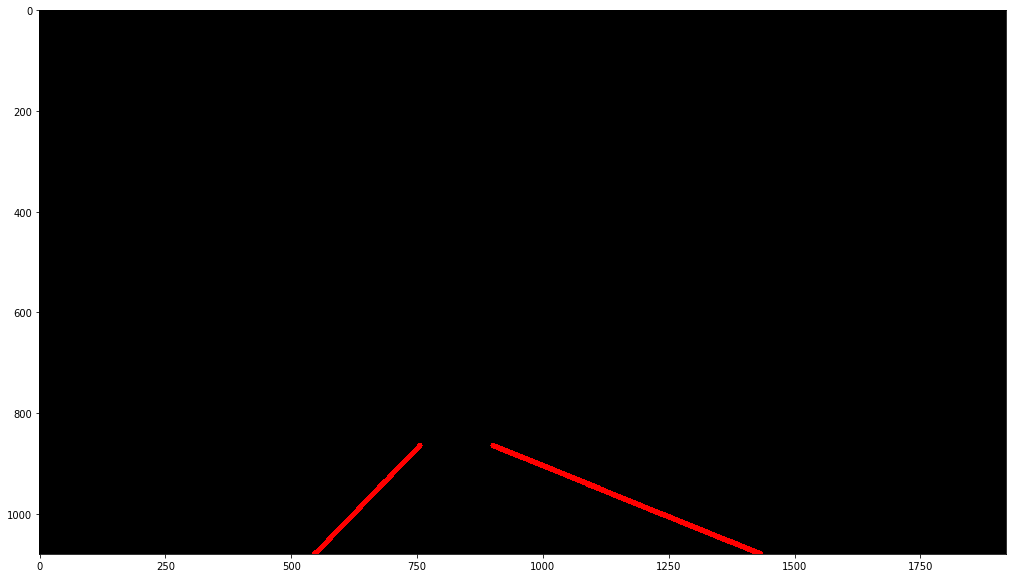

In [8]:
image_test = img.imread("real-test.jpg")  
pipeline(image_test)


### Tesing in vedio

In [9]:
import imageio
from moviepy.editor import VideoFileClip

#### Define process function of each frame

In [10]:
def process_image(image):
    two_color_image = gray_scale(image)
    gray_img = gray_scale(two_color_image)  # gray scale image
    gussian_img = gussian_blur(gray_img,3)  # gussian filter
    canny_img = canny(gussian_img,10,150)   # edge detection
    # draw the ROI mask
    imshape = image.shape
    point1 = (700,imshape[0]*0.8)  # shape[0] denote width
    point2 = (1000,imshape[0]*0.8)
    point3 = (520,970)
    point4 = (1375,970)  # shape[1] denote height
    vertices = np.array([[point1,point2,point4,point3]],dtype=np.int32)
    roi_img = region_of_interest(canny_img,vertices)
    # *** finfinshed  **** 
    # hough line detection and line filter
    hlines_img = hough_lines(roi_img,rho=1,theta=np.pi/180,threshold=25,min_line_len=10,max_line_gap=10)
    #h_lines = hpass_angle_filter(h_lines,threshold_angle) 
    #print ("lines after angle filter",h_lines)
    # draw empty line mask
    
    img_all_lines = weighted_img(hlines_img,image,a=0.7,b=1,r=0.0) # line mask + original image
    return img_all_lines

#### load video and detect

In [11]:
#dir_video = 'test_videos/'
#video_name = ["solidWhiteRight.mp4","challenge.mp4","solidYellowLeft.mp4"]
video_input = "real-test.mp4"
video_output = video_input.split('.')[0]+"_detect.mp4"
clip1 = VideoFileClip(video_input)
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(video_output,audio=False)

contain right lines:  [981, 1066, 1006, 1091, 885, 909, 974, 1031, 1043, 1068]
contain left lines:  [635, 655, 617, 640, 714, 729, 719, 735]
[MoviePy] >>>> Building video real-test_detect.mp4
[MoviePy] Writing video real-test_detect.mp4


  0%|                                                  | 0/480 [00:00<?, ?it/s]

contain right lines:  [981, 1066, 1006, 1091, 885, 909, 974, 1031, 1043, 1068]
contain left lines:  [635, 655, 617, 640, 714, 729, 719, 735]


  0%|                                          | 1/480 [00:00<01:37,  4.90it/s]

contain right lines:  [997, 1066, 1017, 1090, 953, 985, 890, 925, 1019, 1067, 957, 987, 883, 894, 936, 971, 878, 892]
contain left lines:  [713, 728, 719, 733, 618, 632, 637, 648]


  0%|▏                                         | 2/480 [00:00<01:44,  4.58it/s]

contain right lines:  [1031, 1090, 1024, 1077, 1005, 1067, 939, 1000, 1007, 1037, 886, 937, 887, 938, 946, 985, 879, 896, 937, 957, 1048, 1078, 877, 893]
contain left lines:  [710, 727, 716, 732]


  1%|▎                                         | 3/480 [00:00<01:47,  4.42it/s]

contain right lines:  [949, 1012, 965, 986, 967, 985, 939, 950, 888, 921, 924, 946, 1023, 1067, 1047, 1092, 981, 1013, 937, 994, 881, 900, 1038, 1079, 886, 910, 980, 1011, 878, 901, 1040, 1068, 934, 954]
contain left lines:  [708, 727, 715, 731]


  1%|▎                                         | 4/480 [00:00<01:54,  4.16it/s]

contain right lines:  [887, 926, 927, 948, 1063, 1091, 1046, 1064, 878, 902]
contain left lines:  [706, 726, 710, 730]


  1%|▍                                         | 5/480 [00:01<01:53,  4.17it/s]

contain right lines:  [886, 950, 888, 906, 879, 893]
contain left lines:  [710, 728, 704, 724]


  1%|▌                                         | 6/480 [00:01<02:14,  3.53it/s]

contain right lines:  [884, 936, 937, 966, 877, 909]
contain left lines:  [701, 721, 708, 728]


  1%|▌                                         | 7/480 [00:01<02:26,  3.24it/s]

contain right lines:  [884, 920, 879, 912]
contain left lines:  [705, 725, 699, 720]


  2%|▋                                         | 8/480 [00:02<02:19,  3.38it/s]

contain right lines:  [880, 925, 870, 918, 872, 919]
contain left lines:  [704, 725, 697, 720]


  2%|▊                                         | 9/480 [00:02<02:35,  3.02it/s]

contain right lines:  [882, 953, 881, 920, 882, 905]
contain left lines:  [693, 717, 702, 723]


  2%|▊                                        | 10/480 [00:02<02:22,  3.29it/s]

contain right lines:  [873, 937, 884, 925]
contain left lines:  [699, 714, 698, 721, 690, 717]


  2%|▉                                        | 11/480 [00:03<02:14,  3.48it/s]

contain right lines:  [896, 941, 887, 932, 894, 940]
contain left lines:  [696, 711, 701, 721, 687, 714]


  2%|█                                        | 12/480 [00:03<02:03,  3.79it/s]

contain right lines:  [897, 979, 978, 991, 891, 938, 896, 979, 975, 1004, 875, 894, 882, 935, 1008, 1024]
contain left lines:  [684, 714, 693, 719, 694, 721]


  3%|█                                        | 13/480 [00:03<02:06,  3.69it/s]

contain right lines:  [879, 953, 894, 939, 899, 941, 920, 954]
contain left lines:  [689, 717, 679, 712, 695, 720]


  3%|█▏                                       | 14/480 [00:03<02:18,  3.36it/s]

contain right lines:  [892, 1001, 897, 949, 976, 1003, 1025, 1038, 937, 973, 957, 969, 1003, 1033, 959, 970, 988, 1003, 882, 900, 925, 937, 1039, 1057]
contain left lines:  [685, 707, 684, 715, 675, 710]


  3%|█▎                                       | 15/480 [00:04<02:11,  3.54it/s]

contain right lines:  [906, 1013, 900, 958, 889, 904, 908, 970, 992, 1020, 900, 956]
contain left lines:  [671, 708, 681, 707, 680, 704]


  3%|█▎                                       | 16/480 [00:04<02:06,  3.67it/s]

contain right lines:  [901, 977, 904, 966, 911, 954, 894, 908, 1067, 1097, 973, 1015, 1065, 1096, 913, 929]
contain left lines:  [677, 713, 666, 706, 679, 701]


  4%|█▍                                       | 17/480 [00:04<02:06,  3.65it/s]

contain right lines:  [916, 986, 908, 971, 908, 973, 932, 984]
contain left lines:  [662, 705, 677, 711, 672, 711, 660, 703, 674, 713]


  4%|█▌                                       | 18/480 [00:04<01:59,  3.85it/s]

contain right lines:  [914, 975, 911, 982, 907, 1030, 911, 983]
contain left lines:  [655, 700, 667, 709, 671, 700, 657, 702, 666, 694]


  4%|█▌                                       | 19/480 [00:05<01:57,  3.93it/s]

contain right lines:  [921, 1075, 916, 990, 1002, 1020, 1066, 1097]
contain left lines:  [661, 706, 649, 698]


  4%|█▋                                       | 20/480 [00:05<01:55,  3.98it/s]

contain right lines:  [953, 1020, 920, 1001, 927, 980, 908, 924, 1016, 1042, 921, 1003, 1032, 1088]
contain left lines:  [643, 695, 655, 704, 656, 686]


  4%|█▊                                       | 21/480 [00:05<01:51,  4.13it/s]

contain right lines:  [966, 1017, 932, 1030, 909, 961, 925, 1010]
contain left lines:  [634, 659, 652, 692, 665, 701, 649, 692, 660, 688]


  5%|█▉                                       | 22/480 [00:06<02:00,  3.81it/s]

contain right lines:  [929, 1066, 961, 1031, 906, 934, 946, 1009, 918, 942, 938, 950, 938, 993, 1043, 1073, 1022, 1054, 894, 923]
contain left lines:  [626, 690, 641, 697, 651, 699, 677, 690, 653, 671]


  5%|█▉                                       | 23/480 [00:06<01:52,  4.05it/s]

contain right lines:  [947, 1044, 933, 1062, 926, 949, 942, 956, 999, 1045, 897, 927]
contain left lines:  [616, 686, 643, 697, 636, 674, 632, 650, 644, 683]


  5%|██                                       | 24/480 [00:06<01:56,  3.92it/s]

contain right lines:  [903, 947, 919, 1057, 932, 1063, 931, 1059, 951, 1081]
contain left lines:  [647, 694, 613, 684, 610, 685, 627, 651, 659, 693]


  5%|██▏                                      | 25/480 [00:06<01:51,  4.09it/s]

contain right lines:  [948, 1055, 949, 999, 958, 1104, 1006, 1086, 895, 950, 810, 835, 946, 977, 1054, 1084, 984, 1012]
contain left lines:  [620, 679, 631, 691, 635, 676, 660, 688, 634, 680, 613, 661]


  5%|██▏                                      | 26/480 [00:06<01:49,  4.16it/s]

contain right lines:  [966, 1105, 956, 1046, 962, 1057, 892, 925, 910, 921, 955, 1013, 1036, 1077, 812, 841, 1026, 1054]
contain left lines:  [634, 669, 616, 677, 645, 683, 642, 688, 721, 732, 624, 675]


  6%|██▎                                      | 27/480 [00:07<01:52,  4.03it/s]

contain right lines:  [971, 1103, 979, 1076, 963, 1006, 921, 953, 882, 895, 888, 926]
contain left lines:  [650, 683, 620, 672, 638, 683, 652, 680, 617, 654]


  6%|██▍                                      | 28/480 [00:07<01:46,  4.26it/s]

contain right lines:  [968, 1100, 964, 1074, 884, 959, 951, 964, 878, 938, 1004, 1098, 886, 960, 881, 896, 966, 989, 813, 839, 899, 949, 804, 812]
contain left lines:  [645, 679, 627, 669, 641, 669, 623, 641, 723, 738, 644, 668]


  6%|██▍                                      | 29/480 [00:07<01:49,  4.10it/s]

contain right lines:  [990, 1097, 965, 1070, 875, 901, 883, 945, 982, 1071, 920, 934, 918, 968, 805, 813, 883, 918, 823, 838, 814, 845, 1030, 1052]
contain left lines:  [722, 740, 626, 664, 643, 676, 717, 734]


  6%|██▌                                      | 30/480 [00:07<01:55,  3.90it/s]

contain right lines:  [882, 947, 901, 968, 985, 1070, 1003, 1080, 874, 903, 1040, 1096, 982, 1004, 815, 854, 879, 906, 957, 972, 808, 814, 831, 842]
contain left lines:  [629, 658, 645, 671, 644, 670, 628, 659, 789, 817, 723, 742, 649, 664]


  6%|██▋                                      | 31/480 [00:08<02:12,  3.38it/s]

contain right lines:  [1012, 1097, 883, 951, 993, 1071, 879, 907, 1010, 1095, 931, 987, 833, 845, 819, 846]
contain left lines:  [629, 653, 645, 666, 788, 812, 648, 666, 714, 733]


  7%|██▋                                      | 32/480 [00:08<02:07,  3.51it/s]

contain right lines:  [1032, 1100, 1006, 1074, 954, 993, 1002, 1072, 881, 919, 1025, 1085, 955, 989, 956, 1010, 878, 912, 808, 819, 823, 852, 835, 848, 1005, 1073, 874, 910]
contain left lines:  [787, 819, 712, 730, 630, 644, 647, 658]


  7%|██▊                                      | 33/480 [00:08<01:59,  3.74it/s]

contain right lines:  [923, 944, 883, 923, 880, 896, 884, 900, 1034, 1076, 1024, 1073, 1077, 1102, 984, 1004, 1026, 1052, 980, 1005, 1036, 1057, 918, 959, 818, 859, 892, 917, 837, 851, 812, 821, 991, 1017, 962, 982]
contain left lines:  [787, 820, 710, 731]


  7%|██▉                                      | 34/480 [00:09<02:10,  3.42it/s]

contain right lines:  [1052, 1108, 878, 921, 894, 927, 1037, 1081, 839, 857, 823, 858, 812, 823, 1049, 1106]
contain left lines:  [789, 822]


  7%|██▉                                      | 35/480 [00:09<02:07,  3.49it/s]

contain right lines:  [1067, 1114, 815, 825, 1045, 1087, 842, 861, 889, 923, 891, 932, 822, 864]
contain left lines:  [790, 821, 705, 729, 712, 736]


  8%|███                                      | 36/480 [00:09<02:08,  3.45it/s]

contain right lines:  [912, 937, 887, 928, 824, 867, 894, 936, 846, 864, 1070, 1094, 816, 826, 918, 931, 1082, 1120]
contain left lines:  [789, 822, 703, 723]


  8%|███▏                                     | 37/480 [00:10<02:11,  3.37it/s]

contain right lines:  [891, 933, 906, 939, 731, 741, 847, 866, 921, 937, 817, 827, 840, 867, 825, 870, 902, 942, 1099, 1126, 894, 934]
contain left lines:  [790, 822, 697, 720, 709, 733]


  8%|███▏                                     | 38/480 [00:10<02:03,  3.58it/s]

contain right lines:  [895, 939, 904, 945, 828, 877, 819, 827, 851, 867]
contain left lines:  [788, 827, 695, 725, 701, 732]


  8%|███▎                                     | 39/480 [00:10<02:09,  3.39it/s]

contain right lines:  [899, 943, 905, 953, 840, 882, 854, 868, 821, 828, 829, 881]
contain left lines:  [789, 828, 695, 725, 702, 730]


  8%|███▍                                     | 40/480 [00:10<02:02,  3.59it/s]

contain right lines:  [909, 962, 898, 950, 830, 888, 905, 957, 857, 868, 897, 937]
contain left lines:  [789, 827, 696, 729, 688, 722, 793, 832]


  9%|███▌                                     | 41/480 [00:11<02:09,  3.39it/s]

contain right lines:  [905, 968, 832, 890, 898, 956, 839, 894]
contain left lines:  [790, 831, 695, 728, 687, 723]


  9%|███▌                                     | 42/480 [00:11<02:02,  3.58it/s]

contain right lines:  [905, 975, 898, 965, 904, 993, 837, 897, 847, 902]
contain left lines:  [793, 835, 790, 834, 685, 720, 693, 727]


  9%|███▋                                     | 43/480 [00:11<02:26,  2.98it/s]

contain right lines:  [1067, 1092, 839, 909, 905, 1031, 909, 972, 1010, 1046, 1047, 1076, 925, 970, 960, 983, 929, 957, 964, 984]
contain left lines:  [700, 726, 797, 837, 690, 726, 680, 709, 705, 718]


  9%|███▊                                     | 44/480 [00:12<02:32,  2.86it/s]

contain right lines:  [841, 891, 898, 993, 898, 980, 938, 991]
contain left lines:  [817, 840, 715, 725, 686, 702, 675, 705]


  9%|███▊                                     | 45/480 [00:12<02:43,  2.66it/s]

contain right lines:  [924, 1001, 913, 989, 844, 876, 962, 987, 944, 988]
contain left lines:  [680, 721, 669, 714, 693, 725]


 10%|███▉                                     | 46/480 [00:13<02:38,  2.73it/s]

contain right lines:  [888, 993, 944, 1013, 915, 998, 927, 948, 887, 902]
contain left lines:  [677, 720, 661, 714, 688, 706]


 10%|████                                     | 47/480 [00:13<02:35,  2.79it/s]

contain right lines:  [920, 1024, 889, 1010, 968, 1008, 885, 933]
contain left lines:  [681, 719, 671, 709, 672, 681, 670, 719, 658, 711, 656, 682]


 10%|████                                     | 48/480 [00:13<02:41,  2.67it/s]

contain right lines:  [883, 919, 877, 971, 942, 1037, 884, 1033, 959, 1022, 978, 1010, 883, 966]
contain left lines:  [666, 678, 651, 709, 664, 689, 704, 717, 742, 752, 676, 706, 653, 671, 665, 688]


 10%|████▏                                    | 49/480 [00:14<02:46,  2.59it/s]

contain right lines:  [887, 1055, 907, 1035, 961, 1031, 977, 1008, 884, 976, 948, 959, 978, 1053, 978, 1014, 877, 891]
contain left lines:  [657, 683, 700, 714, 690, 705, 643, 672, 693, 708, 743, 753, 658, 680, 739, 749, 646, 670]


 10%|████▎                                    | 50/480 [00:14<02:53,  2.47it/s]

contain right lines:  [939, 1048, 884, 1067, 875, 906, 1000, 1066, 919, 939]
contain left lines:  [647, 702, 654, 712, 637, 705, 688, 702, 646, 665, 738, 748, 743, 756, 672, 711, 672, 713]


 11%|████▎                                    | 51/480 [00:14<02:38,  2.70it/s]

contain right lines:  [944, 1065, 969, 1083, 1045, 1067, 954, 992, 948, 1001, 882, 892]
contain left lines:  [681, 700, 694, 710, 681, 701, 656, 674, 637, 662, 654, 674]


 11%|████▍                                    | 52/480 [00:15<02:58,  2.39it/s]

contain right lines:  [950, 1083, 959, 1102, 886, 901, 996, 1059, 989, 1085, 998, 1020, 884, 906]
contain left lines:  [740, 751, 638, 678, 642, 697, 653, 686, 667, 707, 634, 669, 736, 747, 662, 708, 637, 700, 673, 704]


 11%|████▌                                    | 53/480 [00:15<02:41,  2.65it/s]

contain right lines:  [969, 1024, 957, 1082, 1007, 1112, 930, 1026, 881, 956, 1042, 1110, 889, 930]
contain left lines:  [672, 694, 684, 707, 653, 670, 634, 646, 661, 687, 658, 670, 697, 708, 689, 708, 738, 751]


 11%|████▌                                    | 54/480 [00:16<02:30,  2.82it/s]

contain right lines:  [1059, 1114, 966, 1086, 973, 1112, 975, 1010, 890, 930, 887, 919]
contain left lines:  [740, 750, 681, 691, 667, 701, 614, 669, 650, 690, 624, 672, 737, 750, 733, 746, 613, 663, 647, 696, 650, 702]


 11%|████▋                                    | 55/480 [00:16<02:23,  2.96it/s]

contain right lines:  [968, 1092, 981, 1103, 986, 1026, 894, 913, 890, 922, 1056, 1117, 886, 897, 892, 902]
contain left lines:  [658, 698, 641, 687, 733, 749, 649, 665, 738, 751, 642, 686, 732, 745, 729, 742, 735, 750]


 12%|████▊                                    | 56/480 [00:16<02:46,  2.55it/s]

contain right lines:  [992, 1115, 991, 1096, 976, 1067, 893, 921, 1069, 1097]
contain left lines:  [650, 695, 730, 744, 735, 745, 634, 683, 639, 684, 657, 695, 733, 749]


 12%|████▊                                    | 57/480 [00:17<02:33,  2.75it/s]

contain right lines:  [1001, 1125, 903, 931, 984, 1093, 895, 911, 1000, 1101, 890, 949, 984, 1059]
contain left lines:  [636, 680, 655, 691, 676, 688, 734, 748, 643, 677, 729, 744]


 12%|████▉                                    | 58/480 [00:17<02:22,  2.97it/s]

contain right lines:  [1009, 1125, 993, 1104, 993, 1105, 1002, 1026, 1066, 1129, 899, 925, 892, 916]
contain left lines:  [727, 744, 654, 668, 658, 687, 638, 675, 653, 685, 734, 748, 659, 670]


 12%|█████                                    | 59/480 [00:17<02:40,  2.62it/s]

contain right lines:  [1027, 1133, 1007, 1109, 914, 958, 935, 953, 1010, 1035, 1094, 1110, 1040, 1059, 1049, 1074, 894, 907, 1022, 1036]
contain left lines:  [725, 742, 729, 747, 632, 668, 650, 681, 631, 667, 652, 682, 627, 651]


 12%|█████▏                                   | 60/480 [00:18<02:42,  2.59it/s]

contain right lines:  [1034, 1138, 1016, 1113, 914, 940, 1023, 1126, 1042, 1088, 1067, 1107, 1025, 1099, 1017, 1049, 898, 924, 904, 915]
contain left lines:  [631, 662, 653, 676, 732, 745, 724, 740]


 13%|█████▏                                   | 61/480 [00:18<02:35,  2.69it/s]

contain right lines:  [1028, 1117, 1043, 1141, 1048, 1119, 1050, 1142, 908, 947, 1036, 1073, 899, 941]
contain left lines:  [652, 671, 630, 658, 649, 671, 727, 745, 637, 647, 723, 740]


 13%|█████▎                                   | 62/480 [00:19<02:44,  2.55it/s]

contain right lines:  [1065, 1145, 1088, 1127, 1041, 1108, 1082, 1135, 1065, 1085, 1041, 1120, 1052, 1072, 1057, 1070, 1067, 1085, 908, 945]
contain left lines:  [630, 648, 648, 665, 721, 739, 725, 744]


 13%|█████▍                                   | 63/480 [00:19<03:06,  2.23it/s]

contain right lines:  [1065, 1138, 1056, 1121, 1078, 1148, 902, 924, 1088, 1126, 931, 963, 911, 921, 913, 931, 1054, 1083, 910, 925]
contain left lines:  [725, 743, 718, 739]


 13%|█████▍                                   | 64/480 [00:20<02:55,  2.37it/s]

contain right lines:  [909, 977, 1072, 1124, 1079, 1141, 911, 930, 1095, 1152, 1090, 1124, 1099, 1124, 927, 982, 983, 993, 929, 983, 931, 968]
contain left lines:  [716, 737, 724, 742]


 14%|█████▌                                   | 65/480 [00:20<02:36,  2.65it/s]

contain right lines:  [1117, 1154, 915, 951, 1090, 1120, 907, 932, 1122, 1156]
contain left lines:  [714, 736, 722, 741]


 14%|█████▋                                   | 66/480 [00:20<02:51,  2.41it/s]

contain right lines:  [912, 973, 906, 933, 914, 937]
contain left lines:  [710, 734, 718, 739]


 14%|█████▋                                   | 67/480 [00:21<03:19,  2.07it/s]

contain right lines:  [913, 977, 904, 939, 914, 951]
contain left lines:  [711, 734, 717, 738, 708, 725]


 14%|█████▊                                   | 68/480 [00:21<03:05,  2.22it/s]

contain right lines:  [911, 985, 903, 945, 902, 943]
contain left lines:  [714, 737, 706, 731]


 14%|█████▉                                   | 69/480 [00:22<02:44,  2.49it/s]

contain right lines:  [905, 962, 906, 950]
contain left lines:  [703, 730, 713, 737]


 15%|█████▉                                   | 70/480 [00:22<03:03,  2.24it/s]

contain right lines:  [910, 956, 900, 980, 912, 975]
contain left lines:  [710, 735, 701, 729]


 15%|██████                                   | 71/480 [00:22<02:41,  2.53it/s]

contain right lines:  [897, 977, 887, 960, 915, 973, 927, 964]
contain left lines:  [703, 734, 697, 730, 697, 728]


 15%|██████▏                                  | 72/480 [00:23<02:42,  2.51it/s]

contain right lines:  [880, 896, 913, 971, 898, 978]
contain left lines:  [693, 726, 701, 734, 706, 720, 712, 727]


 15%|██████▏                                  | 73/480 [00:23<02:55,  2.31it/s]

contain right lines:  [921, 976, 903, 986, 920, 949, 875, 901, 970, 986]
contain left lines:  [689, 725, 699, 732, 700, 732, 699, 723]


 15%|██████▎                                  | 74/480 [00:24<03:00,  2.25it/s]

contain right lines:  [899, 1030, 875, 982, 942, 985, 875, 895, 884, 914, 912, 927, 990, 1030]
contain left lines:  [686, 724, 697, 730, 702, 723, 693, 718]


 16%|██████▍                                  | 75/480 [00:24<02:48,  2.41it/s]

contain right lines:  [883, 992, 903, 1028, 897, 929, 918, 947, 949, 993]
contain left lines:  [681, 723, 690, 721, 691, 729, 707, 723]


 16%|██████▍                                  | 76/480 [00:25<03:01,  2.22it/s]

contain right lines:  [872, 908, 910, 1020, 925, 1004, 865, 894, 1020, 1035]
contain left lines:  [747, 757, 675, 718, 688, 726, 751, 760, 685, 710, 695, 726]


 16%|██████▌                                  | 77/480 [00:25<02:41,  2.50it/s]

contain right lines:  [936, 1058, 1029, 1058, 935, 1012, 1028, 1071, 922, 980, 937, 1013, 889, 931, 1002, 1053, 924, 936]
contain left lines:  [669, 716, 682, 724, 744, 756, 681, 724, 694, 718, 747, 760]


 16%|██████▋                                  | 78/480 [00:25<02:24,  2.78it/s]

contain right lines:  [1012, 1081, 887, 1023, 944, 1062, 910, 1019, 927, 954, 936, 1001, 1033, 1069]
contain left lines:  [662, 714, 675, 722, 677, 723, 748, 760, 682, 711, 663, 675, 683, 710]


 16%|██████▋                                  | 79/480 [00:26<02:52,  2.33it/s]

contain right lines:  [920, 1074, 939, 1036, 914, 970, 908, 945, 897, 945, 1002, 1058]
contain left lines:  [651, 709, 667, 720, 666, 718, 684, 712, 680, 697]


 17%|██████▊                                  | 80/480 [00:26<02:39,  2.50it/s]

contain right lines:  [949, 1047, 955, 1042, 911, 951, 975, 1074, 947, 1048, 895, 945, 914, 932]
contain left lines:  [645, 704, 662, 697, 663, 716, 649, 707]


 17%|██████▉                                  | 81/480 [00:27<02:25,  2.73it/s]

contain right lines:  [915, 1079, 952, 1061, 924, 1052, 978, 1059]
contain left lines:  [658, 713, 678, 703, 642, 664, 654, 702, 678, 713]


 17%|███████                                  | 82/480 [00:27<02:47,  2.37it/s]

contain right lines:  [920, 1095, 916, 1077, 948, 1075, 928, 1005, 992, 1094, 932, 958]
contain left lines:  [636, 699, 654, 708, 655, 709, 666, 690]


 17%|███████                                  | 83/480 [00:27<02:30,  2.65it/s]

contain right lines:  [960, 1092, 1043, 1124, 969, 1116, 1019, 1095, 972, 1013]
contain left lines:  [631, 697, 650, 708, 657, 700]


 18%|███████▏                                 | 84/480 [00:28<03:18,  2.00it/s]

contain right lines:  [965, 1117, 979, 1134, 928, 944, 977, 1070, 1033, 1055, 967, 983]
contain left lines:  [650, 690, 658, 700, 628, 680, 648, 687, 647, 702]


 18%|███████▎                                 | 85/480 [00:28<02:58,  2.21it/s]

contain right lines:  [976, 1136, 1022, 1158, 985, 1135, 929, 980, 992, 1137]
contain left lines:  [645, 697, 626, 686, 632, 663]


 18%|███████▎                                 | 86/480 [00:29<03:04,  2.13it/s]

contain right lines:  [992, 1171, 984, 1142, 1041, 1115, 995, 1048, 930, 957, 985, 1079]
contain left lines:  [625, 682, 643, 695, 633, 683, 645, 692]


 18%|███████▍                                 | 87/480 [00:29<02:46,  2.36it/s]

contain right lines:  [1000, 1168, 992, 1141, 991, 1112, 1133, 1169, 938, 994, 932, 949]
contain left lines:  [622, 677, 642, 689, 646, 691, 621, 675]


 18%|███████▌                                 | 88/480 [00:30<02:43,  2.40it/s]

contain right lines:  [1004, 1218, 1001, 1185, 1078, 1217, 1007, 1054, 959, 1007]
contain left lines:  [612, 674, 632, 686, 635, 675, 648, 681, 649, 675, 611, 637]


 19%|███████▌                                 | 89/480 [00:30<03:04,  2.12it/s]

contain right lines:  [1022, 1177, 907, 918, 1009, 1138, 944, 1019, 1009, 1148, 916, 943, 949, 982]
contain left lines:  [627, 667, 648, 679, 650, 680, 727, 735, 656, 680, 730, 743]


 19%|███████▋                                 | 90/480 [00:31<03:07,  2.08it/s]

contain right lines:  [1034, 1180, 1026, 1152, 1083, 1179, 939, 985, 1024, 1150, 913, 969]
contain left lines:  [725, 735, 650, 676, 632, 652, 632, 660, 638, 667, 650, 677]


 19%|███████▊                                 | 91/480 [00:31<02:46,  2.33it/s]

contain right lines:  [1048, 1174, 1036, 1100, 912, 930, 903, 1002, 1062, 1143, 1000, 1048, 909, 921]
contain left lines:  [725, 743, 637, 657, 736, 748, 637, 654, 656, 672]


 19%|███████▊                                 | 92/480 [00:31<02:41,  2.41it/s]

contain right lines:  [902, 1006, 910, 959, 961, 997, 919, 961, 974, 989, 1053, 1144, 987, 1010, 1079, 1170, 901, 996, 1065, 1137, 1005, 1016, 966, 993, 1119, 1172]
contain left lines:  [725, 744, 732, 749, 642, 652]


 19%|███████▉                                 | 93/480 [00:32<02:23,  2.70it/s]

contain right lines:  [1081, 1161, 915, 965, 894, 931, 1068, 1133, 967, 1013, 1067, 1116, 956, 992]
contain left lines:  [731, 748, 726, 743]


 20%|████████                                 | 94/480 [00:32<02:23,  2.69it/s]

contain right lines:  [1100, 1160, 910, 963, 907, 973, 1080, 1131, 894, 915, 978, 1005, 957, 990, 1082, 1116, 921, 936, 956, 1024]
contain left lines:  [720, 740, 728, 747]


 20%|████████                                 | 95/480 [00:33<02:42,  2.36it/s]

contain right lines:  [1121, 1168, 917, 943, 991, 1075, 907, 980, 900, 922, 893, 940, 1102, 1139, 956, 997, 1119, 1138, 1027, 1052]
contain left lines:  [719, 744, 728, 748]


 20%|████████▏                                | 96/480 [00:33<02:34,  2.48it/s]

contain right lines:  [1004, 1058, 1050, 1121, 911, 989, 901, 919, 1017, 1030, 926, 946, 962, 976, 1141, 1168, 1119, 1140, 919, 935, 992, 1042, 960, 993, 970, 981]
contain left lines:  [720, 742, 725, 747]


 20%|████████▎                                | 97/480 [00:33<02:30,  2.54it/s]

contain right lines:  [934, 951, 953, 1058, 1018, 1059, 903, 944, 902, 916, 952, 1014, 937, 959, 918, 934, 914, 925]
contain left lines:  [715, 740, 724, 745]


 20%|████████▎                                | 98/480 [00:34<02:38,  2.41it/s]

contain right lines:  [936, 971, 1005, 1047, 970, 982, 907, 956, 902, 924, 967, 1005, 953, 987]
contain left lines:  [713, 739, 722, 743]


 21%|████████▍                                | 99/480 [00:34<02:37,  2.41it/s]

contain right lines:  [993, 1067, 906, 1015, 907, 962, 949, 997, 1034, 1064, 940, 977, 1064, 1097]
contain left lines:  [719, 745, 710, 739, 710, 735]


 21%|████████▎                               | 100/480 [00:35<02:41,  2.36it/s]

contain right lines:  [907, 1022, 998, 1076, 1090, 1108, 909, 969, 927, 1007, 958, 1003, 1074, 1088]
contain left lines:  [712, 739, 719, 745, 708, 737]


 21%|████████▍                               | 101/480 [00:35<02:22,  2.67it/s]

contain right lines:  [903, 993, 1048, 1086, 902, 1040, 946, 991, 944, 986]
contain left lines:  [712, 739, 717, 743, 706, 736]


 21%|████████▌                               | 102/480 [00:35<02:28,  2.55it/s]

contain right lines:  [905, 999, 907, 984, 962, 999]
contain left lines:  [703, 738, 714, 743, 704, 736]


 21%|████████▌                               | 103/480 [00:36<02:18,  2.72it/s]

contain right lines:  [1073, 1101, 989, 1066, 961, 1010, 909, 990, 924, 983, 1105, 1132, 953, 1002, 1086, 1135, 916, 932, 992, 1041]
contain left lines:  [701, 736, 714, 743, 711, 738]


 22%|████████▋                               | 104/480 [00:36<02:57,  2.12it/s]

contain right lines:  [917, 1002, 921, 1019, 1008, 1081, 913, 980, 978, 1006, 1050, 1091, 1084, 1102, 1000, 1056]
contain left lines:  [710, 743, 697, 736, 710, 742, 701, 733]


 22%|████████▊                               | 105/480 [00:37<02:38,  2.36it/s]

contain right lines:  [910, 1028, 977, 1048, 946, 1046, 979, 1009, 925, 958]
contain left lines:  [707, 734, 706, 742, 693, 733, 709, 742]


 22%|████████▊                               | 106/480 [00:37<02:23,  2.61it/s]

contain right lines:  [919, 1018, 920, 1062, 932, 1015, 961, 1009, 950, 1019]
contain left lines:  [689, 737, 703, 743, 698, 736, 706, 741]


 22%|████████▉                               | 107/480 [00:37<02:21,  2.65it/s]

contain right lines:  [943, 1032, 947, 1049, 963, 1014, 995, 1030]
contain left lines:  [685, 731, 698, 739, 705, 728]


 22%|█████████                               | 108/480 [00:38<02:39,  2.34it/s]

contain right lines:  [955, 1059, 944, 1043, 933, 1009, 925, 1044, 1019, 1059]
contain left lines:  [680, 731, 695, 739, 685, 730]


 23%|█████████                               | 109/480 [00:38<02:24,  2.57it/s]

contain right lines:  [952, 1053, 954, 1083, 953, 1055]
contain left lines:  [675, 730, 690, 738, 702, 737]


 23%|█████████▏                              | 110/480 [00:39<02:11,  2.80it/s]

contain right lines:  [960, 1094, 957, 1070, 973, 1015]
contain left lines:  [685, 737, 670, 728, 686, 726, 699, 736]


 23%|█████████▎                              | 111/480 [00:39<02:25,  2.53it/s]

contain right lines:  [959, 1114, 963, 1085, 905, 948]
contain left lines:  [669, 729, 687, 735, 713, 725, 670, 730, 670, 698]


 23%|█████████▎                              | 112/480 [00:39<02:21,  2.60it/s]

contain right lines:  [974, 1127, 969, 1104, 968, 1076, 976, 1127, 906, 940, 968, 1026]
contain left lines:  [693, 737, 671, 725, 672, 724, 688, 734]


 24%|█████████▍                              | 113/480 [00:40<02:18,  2.64it/s]

contain right lines:  [983, 1141, 977, 1120, 905, 937, 1097, 1142]
contain left lines:  [673, 723, 691, 733, 690, 709, 679, 720]


 24%|█████████▌                              | 114/480 [00:40<02:16,  2.68it/s]

contain right lines:  [983, 1132, 898, 913, 1017, 1085, 1057, 1124, 1087, 1140, 1001, 1032, 994, 1024, 907, 956, 928, 951]
contain left lines:  [756, 766, 762, 770, 761, 770, 676, 721, 694, 732, 692, 732, 675, 720]


 24%|█████████▌                              | 115/480 [00:41<02:21,  2.59it/s]

contain right lines:  [998, 1151, 1030, 1136, 989, 1138, 1050, 1162, 915, 952]
contain left lines:  [756, 766, 681, 719, 693, 730, 677, 714, 694, 725]


 24%|█████████▋                              | 116/480 [00:41<02:25,  2.51it/s]

contain right lines:  [1008, 1163, 997, 1138, 1102, 1164, 1024, 1137, 1006, 1081, 908, 962]
contain left lines:  [761, 769, 677, 716, 695, 728, 678, 717, 694, 728]


 24%|█████████▊                              | 117/480 [00:41<02:11,  2.75it/s]

contain right lines:  [907, 964, 992, 1160, 1005, 1139, 1006, 1140, 978, 991, 1064, 1166]
contain left lines:  [678, 715, 695, 726, 681, 713]


 25%|█████████▊                              | 118/480 [00:42<02:31,  2.39it/s]

contain right lines:  [1022, 1171, 1039, 1144, 974, 994, 1020, 1169, 904, 927, 962, 973, 983, 1040, 909, 960]
contain left lines:  [695, 723, 680, 701, 678, 712, 696, 724, 696, 710, 678, 711]


 25%|█████████▉                              | 119/480 [00:42<02:38,  2.28it/s]

contain right lines:  [1032, 1174, 914, 965, 1024, 1147, 1024, 1128, 1030, 1169, 905, 915, 944, 976]
contain left lines:  [678, 706, 757, 768, 696, 721, 695, 715]


 25%|██████████                              | 120/480 [00:43<03:24,  1.76it/s]

contain right lines:  [1044, 1178, 1035, 1150, 1051, 1086, 915, 943, 917, 981, 1034, 1119, 910, 930]
contain left lines:  [677, 704, 695, 718, 751, 763, 757, 768]


 25%|██████████                              | 121/480 [00:43<02:52,  2.08it/s]

contain right lines:  [1056, 1180, 1081, 1127, 1044, 1107, 993, 1037, 1122, 1153, 917, 938, 918, 933]
contain left lines:  [677, 699, 696, 714, 750, 763, 754, 767, 694, 714]


 25%|██████████▏                             | 122/480 [00:44<02:29,  2.40it/s]

contain right lines:  [1055, 1154, 921, 1029, 1119, 1183, 1018, 1119, 1078, 1127, 1024, 1064, 1024, 1038, 1001, 1061, 1018, 1063, 994, 1027, 1055, 1107, 1023, 1056, 914, 938, 936, 952]
contain left lines:  [695, 710, 750, 764, 749, 761, 676, 697, 679, 696, 669, 698]


 26%|██████████▎                             | 123/480 [00:44<02:43,  2.19it/s]

contain right lines:  [1069, 1158, 1151, 1185, 1011, 1021, 974, 996, 1068, 1105, 946, 974, 1104, 1148, 995, 1028, 920, 943, 930, 947, 1080, 1106]
contain left lines:  [676, 690, 695, 706, 748, 762, 755, 764]


 26%|██████████▎                             | 124/480 [00:45<02:45,  2.15it/s]

contain right lines:  [928, 1021, 1094, 1189, 1082, 1163, 916, 947, 997, 1042, 1081, 1158]
contain left lines:  [747, 761, 675, 685, 694, 701, 753, 765]


 26%|██████████▍                             | 125/480 [00:45<02:30,  2.35it/s]

contain right lines:  [1111, 1191, 1097, 1164, 925, 995, 918, 951, 926, 996, 1110, 1160, 1002, 1046]
contain left lines:  [745, 760, 663, 703]


 26%|██████████▌                             | 126/480 [00:45<02:19,  2.55it/s]

contain right lines:  [930, 995, 1115, 1167, 1162, 1194, 921, 941, 1127, 1158, 1161, 1196]
contain left lines:  [751, 764]


 26%|██████████▌                             | 127/480 [00:46<02:14,  2.63it/s]

contain right lines:  [929, 964, 936, 954, 1184, 1196, 1148, 1176, 921, 956, 1000, 1032, 1135, 1163]
contain left lines:  [750, 763, 743, 757]


 27%|██████████▋                             | 128/480 [00:46<02:45,  2.13it/s]

contain right lines:  [931, 968, 925, 960, 921, 965, 940, 968, 1173, 1194]
contain left lines:  [740, 757, 749, 762]


 27%|██████████▊                             | 129/480 [00:47<02:24,  2.44it/s]

contain right lines:  [923, 967, 932, 974]
contain left lines:  [739, 757, 747, 762]


 27%|██████████▊                             | 130/480 [00:47<02:08,  2.72it/s]

contain right lines:  [931, 980, 927, 971]
contain left lines:  [738, 755, 745, 761]


 27%|██████████▉                             | 131/480 [00:47<02:02,  2.84it/s]

contain right lines:  [930, 978, 931, 984]
contain left lines:  [744, 761, 736, 754]


 28%|███████████                             | 132/480 [00:48<02:30,  2.31it/s]

contain right lines:  [936, 991, 933, 987]
contain left lines:  [628, 673, 743, 760, 733, 754]


 28%|███████████                             | 133/480 [00:48<02:14,  2.57it/s]

contain right lines:  [895, 941, 936, 991, 938, 998, 884, 941, 1008, 1072, 890, 947, 885, 943]
contain left lines:  [621, 657, 741, 759, 718, 745, 731, 751, 727, 747]


 28%|███████████▏                            | 134/480 [00:48<02:04,  2.78it/s]

contain right lines:  [946, 1006, 942, 994, 1008, 1059, 857, 878]
contain left lines:  [616, 654, 729, 751, 740, 757]


 28%|███████████▎                            | 135/480 [00:49<02:20,  2.46it/s]

contain right lines:  [943, 1001, 949, 998, 943, 1015, 859, 882]
contain left lines:  [736, 757, 609, 651, 727, 749, 607, 648]


 28%|███████████▎                            | 136/480 [00:49<02:19,  2.47it/s]

contain right lines:  [950, 1022, 944, 1008, 959, 1023, 843, 862, 862, 892]
contain left lines:  [601, 645, 723, 750, 735, 756]


 29%|███████████▍                            | 137/480 [00:50<02:14,  2.55it/s]

contain right lines:  [953, 1031, 944, 1017, 873, 888, 844, 864]
contain left lines:  [595, 643, 733, 755, 720, 747, 734, 755, 594, 637, 832, 851]


 29%|███████████▌                            | 138/480 [00:50<02:04,  2.74it/s]

contain right lines:  [957, 1041, 948, 1023, 964, 1021, 846, 867, 863, 893, 984, 1040]
contain left lines:  [585, 634, 589, 635, 717, 747, 730, 753]


 29%|███████████▌                            | 139/480 [00:51<02:30,  2.26it/s]

contain right lines:  [958, 1039, 963, 1050, 878, 935, 883, 938, 866, 896, 962, 1016, 847, 869, 855, 890, 909, 930]
contain left lines:  [577, 630, 713, 745, 727, 752, 713, 744]


 29%|███████████▋                            | 140/480 [00:51<02:23,  2.37it/s]

contain right lines:  [959, 1062, 956, 1045, 847, 874, 877, 900]
contain left lines:  [710, 743, 566, 627, 724, 750, 711, 742]


 29%|███████████▊                            | 141/480 [00:51<02:09,  2.62it/s]

contain right lines:  [965, 1059, 973, 1074, 879, 907, 849, 878]
contain left lines:  [719, 749, 554, 616, 705, 740, 563, 619]


 30%|███████████▊                            | 142/480 [00:52<02:22,  2.37it/s]

contain right lines:  [974, 1086, 970, 1071, 882, 908, 850, 878, 858, 899, 973, 1031, 851, 882, 994, 1087, 883, 911]
contain left lines:  [545, 614, 715, 747, 702, 738, 703, 740]


 30%|███████████▉                            | 143/480 [00:52<02:08,  2.63it/s]

contain right lines:  [973, 1086, 983, 1098, 885, 917, 852, 886, 861, 903, 1032, 1097, 884, 914]
contain left lines:  [530, 605, 711, 745, 696, 737, 838, 857, 721, 745]


 30%|████████████                            | 144/480 [00:53<02:33,  2.19it/s]

contain right lines:  [978, 1097, 987, 1088, 900, 927, 862, 886, 1060, 1116, 861, 907, 888, 925]
contain left lines:  [521, 598, 707, 744, 690, 733, 706, 743, 841, 858, 691, 736]


 30%|████████████                            | 145/480 [00:53<02:17,  2.44it/s]

contain right lines:  [992, 1134, 986, 1112, 864, 896, 891, 931, 858, 910]
contain left lines:  [706, 741, 688, 731, 533, 592, 841, 860, 689, 732]


 30%|████████████▏                           | 146/480 [00:53<02:02,  2.73it/s]

contain right lines:  [992, 1133, 998, 1155, 866, 898, 1000, 1155, 895, 932, 895, 937, 866, 916, 1063, 1130]
contain left lines:  [706, 739, 688, 729, 705, 727, 842, 863]


 31%|████████████▎                           | 147/480 [00:54<01:53,  2.94it/s]

contain right lines:  [1006, 1175, 997, 1145, 867, 920, 904, 938, 869, 899, 869, 898]
contain left lines:  [704, 764, 686, 728, 704, 735, 844, 865, 709, 726]


 31%|████████████▎                           | 148/480 [00:54<02:23,  2.31it/s]

contain right lines:  [1013, 1177, 1003, 1173, 903, 941, 875, 900, 867, 926, 1160, 1198, 872, 899]
contain left lines:  [703, 762, 685, 726, 711, 763, 845, 866, 702, 709, 689, 724]


 31%|████████████▍                           | 149/480 [00:55<02:07,  2.59it/s]

contain right lines:  [1021, 1210, 1004, 1161, 872, 932, 874, 900, 1051, 1160, 907, 940, 1023, 1072, 1018, 1127, 870, 931, 1162, 1210]
contain left lines:  [703, 761, 683, 721, 847, 869, 699, 721, 701, 710, 847, 871, 738, 757, 730, 741]


 31%|████████████▌                           | 150/480 [00:55<02:02,  2.70it/s]

contain right lines:  [1018, 1174, 1016, 1171, 1019, 1192, 1076, 1216, 878, 900, 888, 938, 912, 941, 879, 899, 873, 908]
contain left lines:  [701, 730, 681, 707, 850, 870, 685, 719]


 31%|████████████▌                           | 151/480 [00:55<01:57,  2.79it/s]

contain right lines:  [1015, 1187, 1036, 1194, 941, 954, 1015, 1077, 876, 945, 979, 1017, 916, 941, 881, 900, 988, 1005, 1017, 1033, 1178, 1217, 918, 941, 1017, 1160, 1149, 1195, 940, 965]
contain left lines:  [684, 716, 700, 727, 680, 714, 851, 873, 699, 714]


 32%|████████████▋                           | 152/480 [00:56<02:14,  2.44it/s]

contain right lines:  [1027, 1190, 1068, 1224, 1030, 1119, 875, 953, 1044, 1129, 1120, 1216, 927, 941]
contain left lines:  [699, 724, 853, 877, 680, 711, 686, 704, 681, 712]


 32%|████████████▊                           | 153/480 [00:56<02:14,  2.43it/s]

contain right lines:  [1051, 1222, 1031, 1190, 883, 961, 881, 953]
contain left lines:  [681, 707, 856, 880, 700, 720]


 32%|████████████▊                           | 154/480 [00:56<02:08,  2.53it/s]

contain right lines:  [1061, 1219, 1095, 1190, 881, 975, 1043, 1186]
contain left lines:  [753, 758, 746, 753, 681, 702, 861, 884, 701, 717, 688, 703]


 32%|████████████▉                           | 155/480 [00:57<02:11,  2.46it/s]

contain right lines:  [1075, 1217, 1055, 1174, 887, 973, 1056, 1186]
contain left lines:  [701, 713, 744, 752, 871, 888, 682, 698]


 32%|█████████████                           | 156/480 [00:57<02:17,  2.35it/s]

contain right lines:  [913, 939, 1067, 1175, 1081, 1206, 891, 952, 922, 945]
contain left lines:  [702, 710, 686, 694, 743, 754, 749, 761]


 33%|█████████████                           | 157/480 [00:58<02:52,  1.87it/s]

contain right lines:  [1103, 1198, 1094, 1170, 896, 934, 904, 942, 914, 944, 1105, 1201]
contain left lines:  [748, 758, 741, 753]


 33%|█████████████▏                          | 158/480 [00:58<02:25,  2.21it/s]

contain right lines:  [924, 948, 1117, 1194, 904, 942, 1104, 1141, 904, 950, 1131, 1166]


 33%|█████████████▎                          | 159/480 [00:59<02:23,  2.24it/s]

contain right lines:  [1137, 1191, 911, 950, 909, 958, 1120, 1163]
contain left lines:  [739, 750]


 33%|█████████████▎                          | 160/480 [00:59<02:13,  2.39it/s]

contain right lines:  [907, 959, 1144, 1190, 908, 955, 1126, 1162]
contain left lines:  [743, 758]


 34%|█████████████▍                          | 161/480 [01:00<02:10,  2.44it/s]

contain right lines:  [914, 957, 916, 963]
contain left lines:  [742, 756]


 34%|█████████████▌                          | 162/480 [01:00<02:50,  1.87it/s]

contain right lines:  [913, 963, 916, 969]
contain left lines:  [741, 756, 733, 748]


 34%|█████████████▌                          | 163/480 [01:01<02:43,  1.94it/s]

contain right lines:  [992, 1009, 928, 1016, 930, 1023, 920, 973, 946, 1012, 915, 972, 929, 960, 991, 1011, 969, 986, 928, 979, 1011, 1023]
contain left lines:  [732, 748, 740, 755]


 34%|█████████████▋                          | 164/480 [01:01<02:38,  1.99it/s]

contain right lines:  [920, 975, 923, 973]
contain left lines:  [740, 762, 732, 748]


 34%|█████████████▊                          | 165/480 [01:02<02:23,  2.19it/s]

contain right lines:  [919, 978, 926, 985]
contain left lines:  [738, 753, 728, 747, 703, 724, 740, 753]


 35%|█████████████▊                          | 166/480 [01:02<02:24,  2.17it/s]

contain right lines:  [932, 1006, 926, 987, 990, 1003]
contain left lines:  [727, 746, 736, 752]


 35%|█████████████▉                          | 167/480 [01:03<02:13,  2.35it/s]

contain right lines:  [1026, 1061, 1014, 1026, 950, 1029, 929, 1007, 1050, 1085, 927, 990, 1008, 1060, 970, 1043, 948, 1012, 1025, 1060, 1003, 1061, 946, 990, 1050, 1079, 946, 958, 1014, 1058, 947, 987]
contain left lines:  [724, 745, 735, 750, 724, 746]


 35%|██████████████                          | 168/480 [01:03<02:19,  2.24it/s]

contain right lines:  [932, 999, 1071, 1083, 936, 1006, 1065, 1081, 958, 991, 1025, 1067, 994, 1025, 934, 1004, 958, 975]
contain left lines:  [732, 747, 723, 743]


 35%|██████████████                          | 169/480 [01:03<02:04,  2.50it/s]

contain right lines:  [935, 1015, 935, 1003]
contain left lines:  [720, 743, 730, 752]


 35%|██████████████▏                         | 170/480 [01:04<01:54,  2.71it/s]

contain right lines:  [944, 1027, 938, 1012, 940, 1019, 955, 1026]
contain left lines:  [718, 743, 730, 749, 717, 742]


 36%|██████████████▎                         | 171/480 [01:04<02:08,  2.41it/s]

contain right lines:  [943, 1020, 946, 1031, 1022, 1061]
contain left lines:  [727, 750, 715, 742, 716, 727]


 36%|██████████████▎                         | 172/480 [01:05<02:07,  2.41it/s]

contain right lines:  [950, 1037, 945, 1008, 993, 1027]
contain left lines:  [726, 763, 713, 762, 748, 767, 750, 770]


 36%|██████████████▍                         | 173/480 [01:05<02:11,  2.33it/s]

contain right lines:  [954, 1050, 965, 1042]
contain left lines:  [710, 739, 723, 747]


 36%|██████████████▌                         | 174/480 [01:05<02:09,  2.37it/s]

contain right lines:  [954, 1047, 960, 1065]
contain left lines:  [708, 746, 723, 767, 745, 765, 720, 750, 710, 746]


 36%|██████████████▌                         | 175/480 [01:06<02:15,  2.26it/s]

contain right lines:  [965, 1071, 959, 1061, 913, 954, 927, 944]
contain left lines:  [704, 766, 717, 741, 734, 773, 733, 769, 704, 717, 735, 768]


 37%|██████████████▋                         | 176/480 [01:07<02:29,  2.03it/s]

contain right lines:  [964, 1071, 973, 1083, 991, 1024]
contain left lines:  [701, 736, 715, 744, 717, 736]


 37%|██████████████▊                         | 177/480 [01:07<02:41,  1.88it/s]

contain right lines:  [997, 1096, 970, 1084, 973, 1016]
contain left lines:  [697, 736, 713, 744, 712, 742, 698, 734]


 37%|██████████████▊                         | 178/480 [01:08<02:27,  2.05it/s]

contain right lines:  [1004, 1117, 975, 1099, 981, 1066]
contain left lines:  [709, 743, 694, 734, 694, 736]


 37%|██████████████▉                         | 179/480 [01:08<02:32,  1.97it/s]

contain right lines:  [991, 1132, 1037, 1114, 898, 908, 981, 1112, 991, 1004, 912, 988, 923, 1008, 985, 1053]
contain left lines:  [693, 733, 710, 742]


 38%|███████████████                         | 180/480 [01:09<02:43,  1.84it/s]

contain right lines:  [991, 1145, 986, 1129, 1085, 1125, 1074, 1128]
contain left lines:  [694, 733, 711, 741, 705, 731, 706, 716]


 38%|███████████████                         | 181/480 [01:09<02:44,  1.82it/s]

contain right lines:  [995, 1136, 999, 1165]
contain left lines:  [694, 730, 711, 740, 696, 724]


 38%|███████████████▏                        | 182/480 [01:10<02:30,  1.99it/s]

contain right lines:  [1008, 1187, 1025, 1171, 923, 1006, 1001, 1022]
contain left lines:  [696, 731, 712, 740, 713, 740]


 38%|███████████████▎                        | 183/480 [01:10<02:08,  2.31it/s]

contain right lines:  [1007, 1186, 1017, 1211, 931, 1001, 932, 1015, 1012, 1026]
contain left lines:  [697, 731, 714, 739, 718, 739, 696, 728]


 38%|███████████████▎                        | 184/480 [01:11<02:35,  1.90it/s]

contain right lines:  [1019, 1194, 1029, 1217, 936, 982, 1178, 1221]
contain left lines:  [698, 730, 716, 739, 718, 739, 699, 721]


 39%|███████████████▍                        | 185/480 [01:11<02:09,  2.29it/s]

contain right lines:  [1072, 1224, 1076, 1196, 1025, 1072, 935, 969, 1195, 1225, 1043, 1068, 1023, 1051]
contain left lines:  [716, 739, 699, 729, 752, 762, 761, 772, 752, 763, 753, 780]


 39%|███████████████▌                        | 186/480 [01:11<02:06,  2.32it/s]

contain right lines:  [1073, 1108, 1100, 1201, 1120, 1223, 1074, 1203, 1035, 1081, 1088, 1141]
contain left lines:  [718, 738, 700, 728, 701, 718, 732, 738, 763, 774, 754, 768]


 39%|███████████████▌                        | 187/480 [01:12<02:09,  2.26it/s]

contain right lines:  [1044, 1198, 1153, 1233, 1058, 1161, 1178, 1205, 940, 964]
contain left lines:  [703, 718, 719, 731, 755, 780, 719, 726, 754, 764, 703, 727, 719, 736, 761, 779, 768, 776]


 39%|███████████████▋                        | 188/480 [01:12<02:04,  2.34it/s]

contain right lines:  [1104, 1208, 1129, 1241, 1056, 1123, 1082, 1134]
contain left lines:  [721, 738, 704, 727, 766, 776, 763, 770, 715, 725]


 39%|███████████████▊                        | 189/480 [01:13<02:08,  2.27it/s]

contain right lines:  [1068, 1208, 1104, 1239, 1131, 1230, 1083, 1120]
contain left lines:  [758, 781, 711, 725, 760, 782, 756, 768, 757, 775, 757, 773, 723, 732]


 40%|███████████████▊                        | 190/480 [01:13<01:55,  2.51it/s]

contain right lines:  [1082, 1206, 1078, 1093, 1078, 1210, 1194, 1231]
contain left lines:  [706, 722, 725, 735, 710, 718, 767, 784, 763, 778]


 40%|███████████████▉                        | 191/480 [01:14<02:23,  2.01it/s]

contain right lines:  [1088, 1211, 1098, 1231, 1125, 1154, 1185, 1239]
contain left lines:  [764, 774, 709, 721]


 40%|████████████████                        | 192/480 [01:14<02:32,  1.89it/s]

contain right lines:  [1142, 1222, 1102, 1211, 1140, 1240]
contain left lines:  [711, 720]


 40%|████████████████                        | 193/480 [01:15<02:28,  1.93it/s]

contain right lines:  [1144, 1214, 1165, 1243, 1118, 1162, 1204, 1233, 1148, 1234, 1143, 1180, 1119, 1131]


 40%|████████████████▏                       | 194/480 [01:15<02:05,  2.27it/s]

contain right lines:  [1183, 1243, 1140, 1214]


 41%|████████████████▎                       | 195/480 [01:15<01:50,  2.59it/s]

contain right lines:  [1170, 1187, 1202, 1248, 938, 974, 1183, 1219, 943, 978, 1155, 1178]


 41%|████████████████▎                       | 196/480 [01:16<01:47,  2.64it/s]

contain right lines:  [1176, 1215, 1195, 1210, 940, 971, 944, 975]


 41%|████████████████▍                       | 197/480 [01:17<02:35,  1.82it/s]

contain right lines:  [1200, 1221, 947, 981, 1214, 1233, 936, 977]
contain left lines:  [775, 785, 766, 778]


 41%|████████████████▌                       | 198/480 [01:17<02:15,  2.08it/s]

contain right lines:  [949, 983, 947, 983]


 41%|████████████████▌                       | 199/480 [01:18<02:41,  1.74it/s]

contain right lines:  [943, 998, 945, 986]
contain left lines:  [767, 780]


 42%|████████████████▋                       | 200/480 [01:18<02:26,  1.91it/s]

contain right lines:  [951, 994, 954, 996]
contain left lines:  [769, 781]


 42%|████████████████▊                       | 201/480 [01:19<02:41,  1.72it/s]

contain right lines:  [958, 1000, 955, 999]
contain left lines:  [770, 783]


 42%|████████████████▊                       | 202/480 [01:19<02:22,  1.95it/s]

contain right lines:  [961, 999, 963, 1009]
contain left lines:  [770, 783, 780, 790]


 42%|████████████████▉                       | 203/480 [01:20<02:06,  2.20it/s]

contain right lines:  [968, 1013, 968, 1020]
contain left lines:  [780, 791, 770, 786]


 42%|█████████████████                       | 204/480 [01:20<01:55,  2.39it/s]

contain right lines:  [972, 1020, 971, 1024]
contain left lines:  [771, 786, 782, 792]


 43%|█████████████████                       | 205/480 [01:20<02:08,  2.14it/s]

contain right lines:  [974, 1025, 975, 1032, 1006, 1027, 990, 1031]
contain left lines:  [782, 793, 771, 786]


 43%|█████████████████▏                      | 206/480 [01:21<02:04,  2.21it/s]

contain right lines:  [981, 1034, 1014, 1033]
contain left lines:  [771, 786, 786, 794]


 43%|█████████████████▎                      | 207/480 [01:21<02:17,  1.99it/s]

contain right lines:  [1025, 1061, 984, 1041, 983, 1013]
contain left lines:  [771, 788, 783, 795]


 43%|█████████████████▎                      | 208/480 [01:22<02:29,  1.82it/s]

contain right lines:  [986, 1051, 986, 1049]
contain left lines:  [770, 788, 782, 799]


 44%|█████████████████▍                      | 209/480 [01:22<02:09,  2.09it/s]

contain right lines:  [983, 1058, 980, 1046, 979, 1026]
contain left lines:  [782, 795, 773, 787]


 44%|█████████████████▌                      | 210/480 [01:23<02:02,  2.21it/s]

contain right lines:  [994, 1089, 1034, 1073, 996, 1091, 997, 1040, 1038, 1049, 1069, 1116, 997, 1059]
contain left lines:  [769, 787, 783, 795]


 44%|█████████████████▌                      | 211/480 [01:23<01:59,  2.24it/s]

contain right lines:  [1004, 1097, 1019, 1101, 1001, 1068, 1011, 1077, 1025, 1071]
contain left lines:  [767, 787, 781, 795]


 44%|█████████████████▋                      | 212/480 [01:24<01:53,  2.36it/s]

contain right lines:  [1033, 1093, 1079, 1091, 1033, 1105, 1005, 1044, 1002, 1053, 1055, 1081, 1001, 1011, 1031, 1065, 1029, 1063]
contain left lines:  [765, 785, 780, 794]


 44%|█████████████████▊                      | 213/480 [01:24<02:03,  2.15it/s]

contain right lines:  [1005, 1091, 1038, 1104, 1007, 1075, 998, 1061]
contain left lines:  [764, 784, 780, 793]


 45%|█████████████████▊                      | 214/480 [01:24<01:48,  2.45it/s]

contain right lines:  [1015, 1112, 1014, 1049, 1015, 1046, 1052, 1111, 1044, 1088, 1070, 1106]
contain left lines:  [778, 793, 762, 783]


 45%|█████████████████▉                      | 215/480 [01:25<02:05,  2.10it/s]

contain right lines:  [1075, 1100, 1019, 1055, 1022, 1034, 1018, 1058, 1085, 1121, 935, 973, 1017, 1056, 1047, 1058, 1084, 1116, 1089, 1111]
contain left lines:  [760, 783, 776, 792]


 45%|██████████████████                      | 216/480 [01:25<01:57,  2.24it/s]

contain right lines:  [1059, 1131, 1018, 1059, 1043, 1065, 1088, 1119, 1017, 1089, 1102, 1130]
contain left lines:  [757, 781, 775, 792]


 45%|██████████████████                      | 217/480 [01:26<01:45,  2.48it/s]

contain right lines:  [1062, 1122, 1090, 1128, 1073, 1108, 1124, 1147, 1040, 1070, 1114, 1131, 1136, 1151, 1033, 1072]
contain left lines:  [757, 782, 781, 791, 776, 784]


 45%|██████████████████▏                     | 218/480 [01:26<01:39,  2.63it/s]

contain right lines:  [1031, 1080, 1038, 1156, 1073, 1143, 1099, 1154, 1033, 1081, 1085, 1110]
contain left lines:  [777, 790, 758, 781]


 46%|██████████████████▎                     | 219/480 [01:27<02:07,  2.05it/s]

contain right lines:  [1041, 1123, 1041, 1088, 1117, 1166, 1114, 1172, 1123, 1145, 1048, 1144]
contain left lines:  [759, 780, 776, 789, 786, 790]


 46%|██████████████████▎                     | 220/480 [01:27<01:53,  2.29it/s]

contain right lines:  [1220, 1239, 1153, 1170, 1092, 1174, 1049, 1114, 1154, 1174, 1152, 1183, 1051, 1136, 1049, 1135, 1223, 1233, 944, 958, 1173, 1188]
contain left lines:  [759, 779, 777, 789]


 46%|██████████████████▍                     | 221/480 [01:28<01:45,  2.45it/s]

contain right lines:  [1100, 1213, 1229, 1252, 1056, 1178, 1056, 1109, 1175, 1207, 937, 971, 945, 975, 1173, 1203, 1251, 1264, 935, 973, 1144, 1184, 1046, 1075, 1152, 1182, 1052, 1121]
contain left lines:  [760, 778, 778, 789]


 46%|██████████████████▌                     | 222/480 [01:28<01:37,  2.64it/s]

contain right lines:  [1063, 1120, 1113, 1191, 946, 957, 1159, 1225, 1064, 1187, 1156, 1226, 1250, 1276, 1127, 1190]
contain left lines:  [778, 788, 762, 776]


 46%|██████████████████▌                     | 223/480 [01:29<02:09,  1.99it/s]

contain right lines:  [1071, 1138, 1071, 1116, 980, 1002, 1167, 1248, 1122, 1233, 962, 990, 1133, 1204, 1168, 1248, 939, 959, 1180, 1228, 1190, 1249, 1209, 1232]
contain left lines:  [760, 775, 797, 800, 778, 788]


 47%|██████████████████▋                     | 224/480 [01:29<01:51,  2.30it/s]

contain right lines:  [949, 961, 1072, 1146, 1109, 1148, 1133, 1192, 1162, 1270, 1191, 1239, 965, 994, 1076, 1133, 1074, 1109, 1258, 1272, 981, 1002, 977, 1002, 1246, 1272, 958, 970, 1136, 1149]
contain left lines:  [761, 775, 798, 801, 795, 797, 779, 787]


 47%|██████████████████▊                     | 225/480 [01:29<01:37,  2.61it/s]

contain right lines:  [1076, 1121, 1148, 1270, 1240, 1271, 947, 992, 1092, 1158, 1211, 1244, 1097, 1117, 959, 1001, 1122, 1170, 1244, 1265, 1208, 1282, 1174, 1184, 1247, 1299, 1186, 1258, 954, 1001, 968, 1000, 1105, 1136, 1183, 1207, 1207, 1280, 1143, 1162, 1090, 1121]
contain left lines:  [760, 773, 780, 787]


 47%|██████████████████▊                     | 226/480 [01:30<02:09,  1.97it/s]

contain right lines:  [1098, 1190, 1206, 1317, 1229, 1284, 1228, 1269, 1200, 1285, 1257, 1292, 1155, 1194, 1230, 1261, 1100, 1162, 1272, 1311, 1101, 1182, 1217, 1309, 1238, 1319]
contain left lines:  [779, 786, 761, 772]


 47%|██████████████████▉                     | 227/480 [01:31<02:31,  1.67it/s]

contain right lines:  [1122, 1143, 1270, 1292, 1230, 1320, 1074, 1120, 1259, 1286, 954, 995, 972, 1010, 1143, 1191, 955, 999, 1152, 1193, 1257, 1305, 1110, 1185, 1071, 1083, 984, 1004, 1108, 1146, 1201, 1214]
contain left lines:  [761, 771, 780, 785]


 48%|███████████████████                     | 228/480 [01:31<02:08,  1.96it/s]

contain right lines:  [1117, 1191, 1247, 1323, 1121, 1221, 1262, 1298, 1192, 1231, 1256, 1309, 1214, 1255, 1110, 1135, 1206, 1243, 1195, 1231, 1150, 1172, 1232, 1242, 1213, 1236, 1265, 1280, 1224, 1242, 1130, 1154, 1118, 1136]
contain left lines:  [762, 771, 781, 785]


 48%|███████████████████                     | 229/480 [01:31<01:49,  2.29it/s]

contain right lines:  [1088, 1152, 1131, 1228, 1248, 1304, 1088, 1151, 1235, 1268, 1273, 1304, 961, 986, 1140, 1169, 1117, 1143, 1136, 1151, 1233, 1247]
contain left lines:  [797, 799, 763, 769]


 48%|███████████████████▏                    | 230/480 [01:32<01:57,  2.12it/s]

contain right lines:  [1178, 1259, 974, 1032, 1229, 1259, 993, 1034, 980, 994, 960, 1029, 1176, 1201, 1146, 1166, 1174, 1197, 1230, 1248, 1021, 1038, 945, 987, 1295, 1324, 1298, 1330, 1009, 1029]


 48%|███████████████████▎                    | 231/480 [01:32<01:41,  2.45it/s]

contain right lines:  [1159, 1279, 1246, 1284, 1287, 1302, 1225, 1294]


 48%|███████████████████▎                    | 232/480 [01:32<01:33,  2.66it/s]

contain right lines:  [1177, 1291, 1177, 1300, 949, 989, 1263, 1328, 1261, 1295, 1201, 1228, 965, 987, 1254, 1265]
contain left lines:  [690, 707]


 49%|███████████████████▍                    | 233/480 [01:33<01:53,  2.18it/s]

contain right lines:  [1193, 1298, 1192, 1298, 1301, 1322, 1283, 1310, 1229, 1299]


 49%|███████████████████▌                    | 234/480 [01:33<01:39,  2.48it/s]

contain right lines:  [1248, 1299, 1216, 1251, 1002, 1050, 965, 1011, 1247, 1268, 1010, 1050, 956, 1019]


 49%|███████████████████▌                    | 235/480 [01:34<01:48,  2.26it/s]

contain right lines:  [958, 1012, 1232, 1298, 956, 991, 1234, 1293, 1265, 1300, 988, 1013, 968, 1004, 959, 1013]


 49%|███████████████████▋                    | 236/480 [01:34<01:40,  2.44it/s]

contain right lines:  [1253, 1299, 956, 997, 888, 918]
contain left lines:  [696, 725, 680, 699]


 49%|███████████████████▊                    | 237/480 [01:35<01:38,  2.46it/s]

contain right lines:  [974, 994]


 50%|███████████████████▊                    | 238/480 [01:35<01:29,  2.69it/s]

contain right lines:  [894, 926, 880, 910]
contain left lines:  [687, 718, 693, 722, 675, 697]


 50%|███████████████████▉                    | 239/480 [01:36<02:02,  1.97it/s]

contain right lines:  [963, 1016, 882, 914]
contain left lines:  [690, 721, 672, 706]


 50%|████████████████████                    | 240/480 [01:37<02:28,  1.62it/s]

contain right lines:  [968, 982, 968, 1019, 883, 916, 910, 938, 777, 794]
contain left lines:  [668, 693, 687, 719]


 50%|████████████████████                    | 241/480 [01:37<02:41,  1.48it/s]

contain right lines:  [987, 1059, 985, 1054, 912, 933, 886, 916]
contain left lines:  [683, 719, 664, 689]


 50%|████████████████████▏                   | 242/480 [01:38<02:22,  1.67it/s]

contain right lines:  [1021, 1060, 969, 997, 901, 940, 1019, 1047, 887, 921, 1026, 1058]
contain left lines:  [660, 688, 682, 717]


 51%|████████████████████▎                   | 243/480 [01:39<02:37,  1.50it/s]

contain right lines:  [971, 1050, 889, 928, 1025, 1040, 908, 947]
contain left lines:  [675, 716, 656, 686, 680, 711, 792, 798, 681, 705]


 51%|████████████████████▎                   | 244/480 [01:39<02:25,  1.63it/s]

contain right lines:  [973, 1016, 909, 950, 892, 929, 1002, 1015, 1031, 1047]
contain left lines:  [674, 715, 654, 685, 670, 701]


 51%|████████████████████▍                   | 245/480 [01:40<02:10,  1.80it/s]

contain right lines:  [894, 935, 912, 954]
contain left lines:  [649, 682, 670, 713, 672, 705, 792, 799]


 51%|████████████████████▌                   | 246/480 [01:40<02:06,  1.85it/s]

contain right lines:  [976, 1025, 913, 962, 897, 940, 986, 1023, 1044, 1060]
contain left lines:  [666, 712, 644, 693, 661, 706]


 51%|████████████████████▌                   | 247/480 [01:42<03:19,  1.17it/s]

contain right lines:  [1001, 1070, 931, 967, 912, 946, 1050, 1072]
contain left lines:  [640, 677, 665, 698, 665, 706, 664, 709]


 52%|████████████████████▋                   | 248/480 [01:42<02:41,  1.43it/s]

contain right lines:  [935, 973, 902, 951, 1029, 1092, 1033, 1077]
contain left lines:  [637, 675, 657, 703, 656, 709, 793, 799]


 52%|████████████████████▊                   | 249/480 [01:42<02:25,  1.59it/s]

contain right lines:  [905, 957, 940, 984, 1052, 1122, 1038, 1093, 940, 981, 1037, 1066, 921, 960]
contain left lines:  [630, 672, 653, 693, 656, 706, 793, 800, 656, 694]


 52%|████████████████████▊                   | 250/480 [01:43<02:20,  1.64it/s]

contain right lines:  [920, 964, 946, 990, 1030, 1096, 923, 965, 951, 986, 1065, 1099, 808, 808]
contain left lines:  [652, 692, 624, 684, 794, 801, 624, 669]


 52%|████████████████████▉                   | 251/480 [01:44<02:11,  1.74it/s]

contain right lines:  [1027, 1123, 1085, 1133, 1027, 1127, 949, 1000, 926, 971, 1060, 1122, 1051, 1135, 926, 970]
contain left lines:  [650, 697, 617, 666, 796, 801, 645, 691, 643, 685]


 52%|█████████████████████                   | 252/480 [01:44<02:18,  1.65it/s]

contain right lines:  [1001, 1095, 930, 980, 978, 1011, 1015, 1121, 1031, 1119, 953, 1007, 930, 959, 954, 1008]
contain left lines:  [614, 662, 639, 688, 612, 662, 650, 696, 794, 801, 636, 685]


 53%|█████████████████████                   | 253/480 [01:45<02:01,  1.87it/s]

contain right lines:  [958, 1015, 1063, 1130, 934, 985, 812, 812, 961, 1014, 811, 811, 1081, 1118, 809, 810]
contain left lines:  [605, 659, 632, 683, 637, 693, 794, 815, 795, 801]


 53%|█████████████████████▏                  | 254/480 [01:45<01:53,  2.00it/s]

contain right lines:  [984, 1028, 939, 995, 1045, 1055, 1115, 1177, 1159, 1177, 966, 1025, 1018, 1084, 810, 811, 1128, 1179, 1021, 1084, 812, 812]
contain left lines:  [625, 680, 597, 655, 636, 691, 795, 802, 632, 654]


 53%|█████████████████████▎                  | 255/480 [01:46<02:24,  1.56it/s]

contain right lines:  [1107, 1164, 943, 1001, 983, 1034, 1125, 1160, 970, 1034, 947, 1006, 812, 813]
contain left lines:  [588, 650, 620, 679, 647, 689, 617, 676, 798, 803, 631, 669, 795, 811]


 53%|█████████████████████▎                  | 256/480 [01:47<02:19,  1.61it/s]

contain right lines:  [979, 1046, 949, 1016, 1138, 1228, 1140, 1202, 1090, 1104, 813, 814, 1162, 1203, 1186, 1228, 947, 1010, 984, 1036, 806, 806]
contain left lines:  [587, 646, 622, 674, 796, 803, 626, 686, 619, 672, 810, 812, 595, 646]


 54%|█████████████████████▍                  | 257/480 [01:47<02:09,  1.72it/s]

contain right lines:  [953, 1028, 982, 1062, 1131, 1152, 1100, 1119, 1184, 1219, 815, 816]
contain left lines:  [621, 670, 797, 804, 588, 642, 625, 682, 803, 808, 813, 814]


 54%|█████████████████████▌                  | 258/480 [01:47<01:51,  1.99it/s]

contain right lines:  [959, 1040, 989, 1075, 1169, 1210, 815, 817, 1117, 1128, 1040, 1063, 1110, 1124, 990, 1023]
contain left lines:  [615, 678, 622, 666, 590, 636, 798, 805, 623, 661]


 54%|█████████████████████▌                  | 259/480 [01:49<02:32,  1.45it/s]

contain right lines:  [1177, 1278, 999, 1086, 974, 1038, 1177, 1262, 997, 1073, 970, 1008]
contain left lines:  [611, 677, 624, 650, 591, 632, 626, 662, 813, 816, 803, 805]


 54%|█████████████████████▋                  | 260/480 [01:49<02:26,  1.50it/s]

contain right lines:  [975, 1033, 1225, 1304, 1006, 1086, 1199, 1303, 817, 821, 1007, 1040, 1005, 1039, 816, 817, 1206, 1243]
contain left lines:  [602, 675, 593, 626, 803, 805, 626, 656, 808, 810]


 54%|█████████████████████▊                  | 261/480 [01:50<02:14,  1.63it/s]

contain right lines:  [981, 1040, 1013, 1086, 1283, 1331, 1220, 1268, 1297, 1316, 1249, 1289, 1022, 1082, 1148, 1163, 816, 821, 673, 681, 984, 1039]
contain left lines:  [803, 806, 613, 672, 629, 650, 595, 619, 596, 618]


 55%|█████████████████████▊                  | 262/480 [01:50<01:56,  1.88it/s]

contain right lines:  [1192, 1237, 1192, 1225, 991, 1040, 1215, 1284, 1024, 1085, 1158, 1180, 819, 820, 1194, 1237, 820, 822]
contain left lines:  [587, 665, 805, 807]


 55%|█████████████████████▉                  | 263/480 [01:51<02:07,  1.70it/s]

contain right lines:  [1342, 1373, 1288, 1333, 1246, 1324, 997, 1040, 1036, 1086, 1261, 1347, 1160, 1187, 1033, 1084, 1255, 1308, 824, 825, 1162, 1184, 664, 672, 816, 817]
contain left lines:  [577, 662, 806, 807, 576, 623, 807, 808]


 55%|██████████████████████                  | 264/480 [01:51<01:51,  1.93it/s]

contain right lines:  [1185, 1219, 1280, 1311, 1044, 1084, 1186, 1214, 1012, 1039, 976, 976, 822, 824, 660, 667]
contain left lines:  [571, 659, 812, 813, 808, 809]


 55%|██████████████████████                  | 265/480 [01:52<01:50,  1.95it/s]

contain right lines:  [1324, 1342, 971, 990, 1202, 1229, 1201, 1219, 809, 809, 1056, 1084, 984, 984]
contain left lines:  [583, 655]


 55%|██████████████████████▏                 | 266/480 [01:52<01:34,  2.26it/s]

contain right lines:  [1328, 1367, 833, 835, 976, 999, 968, 1005, 818, 830, 822, 843, 991, 994, 811, 811, 822, 843, 826, 826, 977, 996, 824, 846, 828, 830]
contain left lines:  [594, 650, 837, 839, 826, 830, 681, 707]


 56%|██████████████████████▎                 | 267/480 [01:52<01:24,  2.51it/s]

contain right lines:  [1295, 1320, 1229, 1281, 1231, 1273, 812, 812, 1221, 1268, 999, 1004, 976, 1002, 827, 830]
contain left lines:  [609, 644, 672, 709]


 56%|██████████████████████▎                 | 268/480 [01:52<01:19,  2.68it/s]

contain right lines:  [976, 1006, 971, 1007, 1256, 1304, 1280, 1307, 1008, 1015]
contain left lines:  [672, 708, 612, 637]


 56%|██████████████████████▍                 | 269/480 [01:53<01:50,  1.90it/s]

contain right lines:  [984, 1055, 969, 1041, 978, 1058]
contain left lines:  [679, 708]


 56%|██████████████████████▌                 | 270/480 [01:54<01:52,  1.87it/s]

contain right lines:  [1034, 1100, 979, 1017, 969, 1016, 1304, 1331]
contain left lines:  [679, 708]


 56%|██████████████████████▌                 | 271/480 [01:54<01:36,  2.18it/s]

contain right lines:  [1041, 1091, 971, 1030, 980, 1023]
contain left lines:  [684, 707]


 57%|██████████████████████▋                 | 272/480 [01:54<01:22,  2.53it/s]

contain right lines:  [984, 1025, 1053, 1084, 975, 1028]


 57%|██████████████████████▊                 | 273/480 [01:55<01:17,  2.66it/s]

contain right lines:  [982, 1030, 989, 1036]


 57%|██████████████████████▊                 | 274/480 [01:55<01:34,  2.19it/s]

contain right lines:  [984, 1040, 995, 1039]


 57%|██████████████████████▉                 | 275/480 [01:56<01:23,  2.46it/s]

contain right lines:  [988, 1039, 998, 1041]


 57%|███████████████████████                 | 276/480 [01:56<01:14,  2.74it/s]

contain right lines:  [1000, 1047, 991, 1046]


 58%|███████████████████████                 | 277/480 [01:57<01:29,  2.27it/s]

contain right lines:  [995, 1053]


 58%|███████████████████████▏                | 278/480 [01:57<01:23,  2.41it/s]

contain right lines:  [997, 1061]


 58%|███████████████████████▎                | 279/480 [01:57<01:17,  2.59it/s]

contain right lines:  [1005, 1072]


 58%|███████████████████████▎                | 280/480 [01:57<01:11,  2.80it/s]

contain right lines:  [821, 823, 1029, 1083]


 59%|███████████████████████▍                | 281/480 [01:59<01:55,  1.73it/s]

contain right lines:  [823, 825]


 59%|███████████████████████▌                | 282/480 [01:59<01:36,  2.05it/s]

contain right lines:  [824, 826]


 59%|███████████████████████▌                | 283/480 [01:59<01:23,  2.35it/s]

contain right lines:  [825, 829]


 59%|███████████████████████▋                | 284/480 [01:59<01:12,  2.71it/s]

contain right lines:  [826, 830]


 59%|███████████████████████▊                | 285/480 [02:00<01:21,  2.38it/s]

contain right lines:  [827, 832]


 60%|███████████████████████▊                | 286/480 [02:00<01:15,  2.56it/s]

contain right lines:  [828, 834, 835, 846]


 60%|███████████████████████▉                | 287/480 [02:01<01:18,  2.46it/s]

contain right lines:  [829, 835, 838, 848, 1037, 1100]
contain left lines:  [672, 706]


 60%|████████████████████████                | 288/480 [02:01<01:21,  2.36it/s]

contain right lines:  [1043, 1111, 838, 851, 831, 837]
contain left lines:  [667, 708]


 60%|████████████████████████                | 289/480 [02:02<01:18,  2.44it/s]

contain right lines:  [1050, 1111, 832, 840, 840, 853]
contain left lines:  [662, 709]


 60%|████████████████████████▏               | 290/480 [02:02<01:09,  2.72it/s]

contain right lines:  [833, 840, 1056, 1129, 841, 856]
contain left lines:  [668, 712, 672, 706, 657, 708]


 61%|████████████████████████▎               | 291/480 [02:02<01:05,  2.90it/s]

contain right lines:  [835, 843, 843, 859, 1068, 1129]
contain left lines:  [649, 714, 667, 707]


 61%|████████████████████████▎               | 292/480 [02:03<01:18,  2.39it/s]

contain right lines:  [1067, 1122, 836, 846, 845, 862]
contain left lines:  [674, 714, 645, 699, 671, 705]


 61%|████████████████████████▍               | 293/480 [02:03<01:18,  2.37it/s]

contain right lines:  [837, 849, 846, 865]
contain left lines:  [642, 715, 667, 708]


 61%|████████████████████████▌               | 294/480 [02:04<01:20,  2.32it/s]

contain right lines:  [838, 851, 853, 869]
contain left lines:  [640, 715, 672, 705, 667, 709]


 61%|████████████████████████▌               | 295/480 [02:04<01:32,  1.99it/s]

contain right lines:  [850, 873, 840, 854]
contain left lines:  [640, 698, 662, 708, 650, 682]


 62%|████████████████████████▋               | 296/480 [02:05<01:28,  2.07it/s]

contain right lines:  [842, 873, 841, 856, 866, 875]
contain left lines:  [640, 715, 667, 710, 637, 716]


 62%|████████████████████████▊               | 297/480 [02:05<01:16,  2.40it/s]

contain right lines:  [843, 858, 859, 877]
contain left lines:  [635, 705, 667, 709, 699, 716, 640, 715]


 62%|████████████████████████▊               | 298/480 [02:05<01:14,  2.45it/s]

contain right lines:  [845, 860, 873, 879]
contain left lines:  [633, 716, 662, 710, 649, 715]


 62%|████████████████████████▉               | 299/480 [02:06<01:06,  2.71it/s]

contain right lines:  [847, 861, 865, 871]
contain left lines:  [643, 705, 657, 708, 697, 715, 695, 709]


 62%|█████████████████████████               | 300/480 [02:06<01:08,  2.63it/s]

contain right lines:  [849, 862, 867, 881, 855, 862]
contain left lines:  [647, 701, 663, 679, 628, 661, 662, 708]


 63%|█████████████████████████               | 301/480 [02:06<01:00,  2.94it/s]

contain right lines:  [851, 864, 870, 879, 858, 864]
contain left lines:  [633, 709, 628, 715, 662, 709]


 63%|█████████████████████████▏              | 302/480 [02:07<01:16,  2.34it/s]

contain right lines:  [853, 866, 863, 886]
contain left lines:  [641, 700, 672, 707, 657, 713, 667, 709]


 63%|█████████████████████████▎              | 303/480 [02:07<01:10,  2.53it/s]

contain right lines:  [877, 887, 855, 868]
contain left lines:  [633, 713, 667, 708]


 63%|█████████████████████████▎              | 304/480 [02:07<01:03,  2.79it/s]

contain right lines:  [858, 870, 880, 889, 867, 875]
contain left lines:  [633, 696, 649, 713, 678, 707]


 64%|█████████████████████████▍              | 305/480 [02:08<01:01,  2.83it/s]

contain right lines:  [861, 872, 886, 891]
contain left lines:  [640, 712, 672, 706]


 64%|█████████████████████████▌              | 306/480 [02:09<01:40,  1.73it/s]

contain right lines:  [838, 842, 864, 874, 843, 848]
contain left lines:  [641, 710, 640, 676, 679, 705]


 64%|█████████████████████████▌              | 307/480 [02:09<01:23,  2.06it/s]

contain right lines:  [867, 876, 844, 850]
contain left lines:  [645, 711, 639, 704]


 64%|█████████████████████████▋              | 308/480 [02:09<01:10,  2.44it/s]

contain right lines:  [839, 845]
contain left lines:  [645, 710, 678, 706]


 64%|█████████████████████████▊              | 309/480 [02:10<01:11,  2.39it/s]

contain right lines:  [875, 879, 886, 893]
contain left lines:  [645, 710, 679, 705]


 65%|█████████████████████████▊              | 310/480 [02:10<01:05,  2.61it/s]

contain left lines:  [633, 713, 647, 709, 669, 706]


 65%|█████████████████████████▉              | 311/480 [02:11<01:23,  2.01it/s]

contain left lines:  [622, 713, 623, 677, 662, 709]


 65%|██████████████████████████              | 312/480 [02:11<01:12,  2.33it/s]

contain left lines:  [616, 716, 662, 710, 610, 675]


 65%|██████████████████████████              | 313/480 [02:11<01:02,  2.66it/s]

contain left lines:  [594, 659, 649, 713, 661, 719, 676, 703]


 65%|██████████████████████████▏             | 314/480 [02:12<00:55,  3.01it/s]

contain left lines:  [594, 721, 633, 716, 664, 706, 582, 607]


 66%|██████████████████████████▎             | 315/480 [02:12<01:10,  2.33it/s]

contain left lines:  [628, 718, 571, 719, 662, 710, 679, 709]


 66%|██████████████████████████▎             | 316/480 [02:13<01:02,  2.62it/s]

contain left lines:  [550, 706, 623, 717, 560, 674, 616, 721, 652, 709, 708, 726, 674, 711]


 66%|██████████████████████████▍             | 317/480 [02:13<00:58,  2.77it/s]

contain right lines:  [848, 859]
contain left lines:  [538, 701, 611, 722, 608, 723, 640, 702, 667, 714, 675, 721]


 66%|██████████████████████████▌             | 318/480 [02:14<01:16,  2.11it/s]

contain right lines:  [849, 861]
contain left lines:  [605, 725, 526, 698, 628, 710, 642, 705, 662, 716, 594, 616, 548, 625]


 66%|██████████████████████████▌             | 319/480 [02:14<01:15,  2.14it/s]

contain right lines:  [857, 872, 851, 862]
contain left lines:  [520, 708, 598, 726, 618, 719, 669, 718, 589, 682]


 67%|██████████████████████████▋             | 320/480 [02:14<01:05,  2.44it/s]

contain right lines:  [852, 865, 859, 875]
contain left lines:  [522, 711, 586, 729, 611, 707, 657, 718, 631, 710, 577, 629]


 67%|██████████████████████████▊             | 321/480 [02:15<01:08,  2.31it/s]

contain right lines:  [861, 877, 853, 868]
contain left lines:  [523, 704, 572, 639, 605, 685, 646, 720, 650, 722, 595, 730, 647, 697, 529, 594]


 67%|██████████████████████████▊             | 322/480 [02:15<01:05,  2.40it/s]

contain right lines:  [855, 870, 863, 880]
contain left lines:  [525, 719, 594, 731, 606, 723, 573, 699, 572, 706, 647, 721, 708, 736, 599, 682]


 67%|██████████████████████████▉             | 323/480 [02:16<01:09,  2.25it/s]

contain right lines:  [856, 874, 864, 884]
contain left lines:  [580, 732, 525, 719, 644, 723, 583, 709, 645, 721, 567, 628, 706, 736, 599, 644, 650, 686]


 68%|███████████████████████████             | 324/480 [02:16<01:02,  2.51it/s]

contain right lines:  [858, 875, 866, 887]
contain left lines:  [571, 639, 599, 703, 690, 722, 526, 587, 575, 699, 650, 722, 624, 731, 527, 716]


 68%|███████████████████████████             | 325/480 [02:16<00:58,  2.67it/s]

contain right lines:  [867, 890, 859, 878]
contain left lines:  [526, 715, 661, 721, 578, 732, 575, 695, 599, 646, 650, 708, 640, 684, 723, 737, 623, 715, 567, 611, 552, 583]


 68%|███████████████████████████▏            | 326/480 [02:17<01:08,  2.25it/s]

contain right lines:  [861, 881, 870, 893, 861, 882, 852, 872]
contain left lines:  [539, 714, 580, 731, 636, 705, 599, 667, 654, 715, 708, 736, 567, 613, 621, 730, 534, 565]


 68%|███████████████████████████▎            | 327/480 [02:17<00:59,  2.55it/s]

contain right lines:  [863, 885, 872, 898]
contain left lines:  [544, 719, 617, 731, 571, 674, 527, 602, 611, 696, 647, 722, 715, 725, 585, 613, 702, 735, 599, 651]


 68%|███████████████████████████▎            | 328/480 [02:18<01:02,  2.43it/s]

contain right lines:  [865, 888, 872, 901]
contain left lines:  [565, 712, 560, 708, 594, 693, 528, 653, 688, 721, 709, 735, 645, 683, 698, 735, 599, 621, 629, 731]


 69%|███████████████████████████▍            | 329/480 [02:18<00:55,  2.71it/s]

contain right lines:  [875, 906, 866, 893, 886, 902, 868, 878, 866, 893, 866, 891]
contain left lines:  [529, 666, 550, 712, 582, 723, 642, 738, 645, 716, 603, 677]


 69%|███████████████████████████▌            | 330/480 [02:18<01:00,  2.49it/s]

contain right lines:  [868, 896, 878, 910, 872, 897]
contain left lines:  [536, 738, 543, 707, 667, 734, 589, 720, 640, 723, 712, 740, 581, 652]


 69%|███████████████████████████▌            | 331/480 [02:19<01:18,  1.89it/s]

contain right lines:  [870, 901, 881, 916, 880, 907]
contain left lines:  [550, 741, 526, 735, 577, 731, 632, 727, 534, 597, 571, 638, 650, 703]


 69%|███████████████████████████▋            | 332/480 [02:20<01:17,  1.92it/s]

contain right lines:  [873, 906, 885, 923, 904, 912, 883, 908]
contain left lines:  [521, 586, 703, 738, 602, 710, 536, 744, 555, 683, 623, 729, 523, 683, 624, 726, 520, 711, 537, 641]


 69%|███████████████████████████▊            | 333/480 [02:20<01:25,  1.72it/s]

contain right lines:  [875, 912, 887, 928, 850, 856, 875, 898]
contain left lines:  [522, 717, 555, 715, 541, 692, 616, 731, 669, 745, 545, 585, 703, 741, 684, 712]


 70%|███████████████████████████▊            | 334/480 [02:21<01:15,  1.94it/s]

contain right lines:  [878, 913, 888, 934, 907, 918, 889, 922, 907, 917, 882, 916, 880, 915]
contain left lines:  [524, 720, 573, 699, 553, 689, 698, 734, 699, 727, 612, 697, 549, 601, 538, 586, 527, 564, 704, 748, 695, 730, 672, 711, 651, 701, 698, 737]


 70%|███████████████████████████▉            | 335/480 [02:21<01:07,  2.16it/s]

contain right lines:  [881, 917, 892, 935, 882, 907, 889, 902, 883, 894]
contain left lines:  [526, 744, 695, 749, 521, 681, 544, 690, 606, 732, 551, 693, 671, 739, 579, 690, 556, 587, 533, 574]


 70%|████████████████████████████            | 336/480 [02:21<00:59,  2.42it/s]

contain right lines:  [883, 919, 896, 925, 858, 866, 895, 935, 883, 917]
contain left lines:  [521, 662, 563, 747, 690, 720, 529, 641, 594, 723, 615, 714, 545, 635, 615, 681, 636, 750, 605, 681, 548, 624, 554, 566, 701, 745]


 70%|████████████████████████████            | 337/480 [02:22<01:03,  2.23it/s]

contain right lines:  [886, 919, 897, 932, 854, 862, 857, 867, 887, 920]
contain left lines:  [613, 689, 598, 722, 520, 664, 546, 688, 571, 740, 531, 745, 676, 749, 701, 735, 705, 750, 601, 724, 566, 702]


 70%|████████████████████████████▏           | 338/480 [02:22<01:02,  2.26it/s]

contain right lines:  [859, 869, 889, 921, 902, 939, 890, 922, 901, 938, 854, 863]
contain left lines:  [530, 620, 667, 749, 546, 598, 529, 743, 599, 725, 522, 685, 546, 739, 565, 664, 712, 744, 594, 682]


 71%|████████████████████████████▎           | 339/480 [02:23<00:58,  2.41it/s]

contain right lines:  [907, 943, 893, 924, 907, 937, 919, 934, 893, 909]
contain left lines:  [528, 733, 547, 721, 638, 738, 692, 732, 599, 718, 526, 624, 696, 747, 600, 743, 625, 673]


 71%|████████████████████████████▎           | 340/480 [02:24<01:18,  1.79it/s]

contain right lines:  [857, 865, 911, 945, 896, 927]
contain left lines:  [530, 698, 571, 732, 546, 697, 545, 746, 611, 716, 528, 595, 596, 741, 606, 697, 665, 730]


 71%|████████████████████████████▍           | 341/480 [02:24<01:07,  2.06it/s]

contain right lines:  [917, 949, 858, 867, 900, 930, 910, 949]
contain left lines:  [537, 733, 575, 728, 543, 743, 618, 720, 527, 570, 596, 738, 568, 599, 570, 675, 574, 598, 597, 693]


 71%|████████████████████████████▌           | 342/480 [02:24<00:58,  2.36it/s]

contain right lines:  [904, 932, 925, 952, 916, 951, 863, 875, 859, 868]
contain left lines:  [543, 725, 544, 673, 525, 707, 623, 722, 663, 736, 681, 740, 621, 694, 571, 654, 560, 683, 647, 715]


 71%|████████████████████████████▌           | 343/480 [02:25<01:03,  2.15it/s]

contain right lines:  [928, 955, 908, 924, 909, 935, 921, 946]
contain left lines:  [523, 671, 583, 739, 555, 728, 635, 734, 651, 722, 626, 722, 542, 607, 636, 676, 543, 608]


 72%|████████████████████████████▋           | 344/480 [02:25<00:59,  2.30it/s]

contain right lines:  [914, 937, 942, 958, 926, 958, 866, 879]
contain left lines:  [522, 667, 572, 737, 524, 557, 560, 725, 540, 629, 643, 718, 635, 732]


 72%|████████████████████████████▊           | 345/480 [02:26<00:59,  2.28it/s]

contain right lines:  [933, 961, 919, 940, 862, 874, 868, 882]
contain left lines:  [582, 724, 545, 619, 573, 736, 567, 722, 669, 716, 559, 697, 637, 683, 696, 725, 525, 568]


 72%|████████████████████████████▊           | 346/480 [02:26<00:52,  2.56it/s]

contain right lines:  [939, 965, 925, 943, 869, 884, 864, 875]
contain left lines:  [524, 729, 540, 713, 567, 717, 576, 661, 639, 716, 591, 612, 693, 734, 684, 724, 666, 721]


 72%|████████████████████████████▉           | 347/480 [02:26<00:58,  2.29it/s]

contain right lines:  [946, 967, 865, 877, 870, 886, 931, 946]
contain left lines:  [533, 729, 542, 734, 567, 703, 544, 665, 609, 728, 633, 714, 625, 670, 555, 628, 682, 724]


 72%|█████████████████████████████           | 348/480 [02:27<00:55,  2.37it/s]

contain right lines:  [958, 968, 866, 880, 872, 888]
contain left lines:  [538, 725, 528, 729, 543, 735, 525, 582, 654, 718, 692, 736, 693, 730, 628, 651, 619, 647]


 73%|█████████████████████████████           | 349/480 [02:27<00:51,  2.53it/s]

contain right lines:  [870, 884, 873, 891]
contain left lines:  [546, 737, 680, 726, 540, 724, 554, 684, 633, 718, 528, 637, 716, 732, 526, 609, 623, 703]


 73%|█████████████████████████████▏          | 350/480 [02:28<00:47,  2.74it/s]

contain right lines:  [869, 885, 871, 894]
contain left lines:  [548, 737, 543, 669, 558, 737, 549, 708, 611, 701, 531, 628, 521, 582, 661, 689, 620, 705, 680, 723, 678, 712]


 73%|█████████████████████████████▎          | 351/480 [02:28<01:07,  1.92it/s]

contain right lines:  [876, 896, 871, 888]
contain left lines:  [552, 723, 535, 736, 524, 722, 687, 741, 596, 706, 641, 731, 609, 626, 534, 644, 558, 738, 667, 720]


 73%|█████████████████████████████▎          | 352/480 [02:29<01:01,  2.09it/s]

contain right lines:  [879, 899, 872, 891]
contain left lines:  [531, 709, 590, 743, 539, 738, 603, 727, 585, 637, 570, 633, 641, 674, 641, 722, 684, 726]


 74%|█████████████████████████████▍          | 353/480 [02:29<00:54,  2.34it/s]

contain right lines:  [879, 903, 873, 893]
contain left lines:  [562, 746, 544, 744, 583, 710, 679, 736, 573, 699, 594, 743, 543, 664, 535, 677, 691, 730, 560, 644]


 74%|█████████████████████████████▌          | 354/480 [02:29<00:50,  2.48it/s]

contain right lines:  [876, 898, 883, 902]
contain left lines:  [694, 736, 565, 748, 536, 681, 547, 718, 610, 701, 575, 639, 679, 707, 719, 743, 555, 582, 546, 558, 701, 732, 552, 593]


 74%|█████████████████████████████▌          | 355/480 [02:30<00:47,  2.62it/s]

contain right lines:  [887, 910, 877, 899]
contain left lines:  [727, 739, 567, 735, 549, 721, 538, 679, 543, 653, 550, 706, 549, 700, 664, 694, 679, 749, 707, 733, 732, 744, 692, 738, 712, 731]


 74%|█████████████████████████████▋          | 356/480 [02:30<00:53,  2.33it/s]

contain right lines:  [880, 904, 885, 914]
contain left lines:  [682, 720, 568, 728, 543, 697, 543, 714, 551, 710, 538, 654, 552, 601, 542, 586, 692, 727, 730, 749, 707, 742, 706, 737]


 74%|█████████████████████████████▊          | 357/480 [02:31<00:49,  2.46it/s]

contain right lines:  [881, 908, 889, 918]
contain left lines:  [533, 671, 582, 708, 585, 712, 570, 728, 723, 739, 553, 602, 688, 721, 686, 718, 543, 582, 556, 704, 717, 748, 623, 697, 571, 683, 664, 727, 700, 733, 656, 689, 547, 581, 556, 615]


 75%|█████████████████████████████▊          | 358/480 [02:31<00:44,  2.72it/s]

contain right lines:  [889, 921, 883, 910]
contain left lines:  [544, 653, 555, 737, 573, 749, 587, 733, 617, 738, 572, 632, 536, 667, 608, 707, 626, 726, 526, 592, 731, 744, 673, 703]


 75%|█████████████████████████████▉          | 359/480 [02:31<00:43,  2.76it/s]

contain right lines:  [893, 926, 885, 915]
contain left lines:  [573, 746, 635, 696, 557, 715, 711, 740, 626, 739, 576, 726, 527, 643, 603, 665, 547, 586, 520, 607, 697, 733, 595, 610, 724, 749, 573, 616]


 75%|██████████████████████████████          | 360/480 [02:32<00:41,  2.86it/s]

contain right lines:  [895, 932, 889, 920, 887, 917]
contain left lines:  [574, 738, 556, 716, 546, 696, 623, 688, 521, 637, 722, 746, 575, 718, 558, 659, 520, 599, 683, 710, 576, 646, 692, 732, 642, 654, 654, 699, 657, 685, 712, 749, 642, 655, 675, 726, 682, 695, 557, 678]


 75%|██████████████████████████████          | 361/480 [02:32<00:49,  2.38it/s]

contain right lines:  [889, 924, 898, 937, 889, 910, 895, 935]
contain left lines:  [639, 731, 633, 694, 577, 743, 520, 682, 573, 654, 606, 734, 548, 603, 578, 589, 693, 727, 716, 741, 558, 604, 580, 651, 628, 687, 620, 663, 606, 636, 712, 748, 696, 730, 603, 663, 546, 566, 569, 643, 724, 736, 600, 677]


 75%|██████████████████████████████▏         | 362/480 [02:32<00:43,  2.70it/s]

contain right lines:  [891, 931, 899, 942, 893, 911, 900, 942, 919, 934]
contain left lines:  [559, 691, 591, 716, 573, 696, 580, 687, 609, 747, 558, 677, 694, 727, 685, 730, 634, 707, 534, 555, 708, 736, 609, 633, 521, 547, 547, 607, 540, 588, 676, 741]


 76%|██████████████████████████████▎         | 363/480 [02:33<00:52,  2.21it/s]

contain right lines:  [894, 934, 902, 948, 909, 935, 905, 948]
contain left lines:  [592, 746, 547, 704, 563, 679, 574, 716, 680, 729, 578, 688, 575, 745, 711, 740, 521, 558, 659, 691, 557, 583, 699, 732, 690, 739, 540, 560, 520, 536, 572, 628]


 76%|██████████████████████████████▎         | 364/480 [02:33<00:50,  2.28it/s]

contain right lines:  [905, 955, 896, 929, 900, 940, 894, 906, 904, 953, 927, 946]
contain left lines:  [658, 711, 577, 731, 557, 738, 523, 690, 574, 744, 686, 727, 586, 676, 624, 637, 579, 709, 520, 550, 574, 637, 600, 717, 548, 583, 608, 698]


 76%|██████████████████████████████▍         | 365/480 [02:34<00:50,  2.26it/s]

contain right lines:  [908, 962, 927, 947, 913, 941, 922, 956, 929, 939, 900, 916, 907, 930]
contain left lines:  [547, 684, 527, 684, 574, 737, 558, 706, 520, 547, 615, 732, 577, 704, 651, 726, 702, 738, 624, 700, 578, 623, 706, 743, 703, 733, 617, 628, 678, 725]


 76%|██████████████████████████████▌         | 366/480 [02:34<00:45,  2.52it/s]

contain right lines:  [910, 972, 901, 953, 930, 959, 933, 954, 911, 960]
contain left lines:  [596, 742, 528, 670, 547, 682, 562, 670, 553, 639, 676, 737, 690, 715, 628, 684, 625, 672, 671, 725, 615, 688, 701, 722, 661, 689, 574, 600, 698, 729, 551, 598, 685, 741, 589, 605, 605, 627]


 76%|██████████████████████████████▌         | 367/480 [02:35<00:42,  2.67it/s]

contain right lines:  [915, 978, 911, 963, 930, 969, 913, 976, 904, 921]
contain left lines:  [532, 724, 560, 736, 576, 691, 549, 707, 563, 691, 573, 711, 607, 718, 692, 732, 707, 741, 522, 550, 699, 735, 585, 680, 693, 726]


 77%|██████████████████████████████▋         | 368/480 [02:35<00:51,  2.16it/s]

contain right lines:  [908, 972, 916, 969, 928, 979, 917, 988, 907, 922, 930, 976]
contain left lines:  [711, 736, 581, 735, 562, 710, 529, 677, 527, 723, 552, 690, 681, 737, 677, 706, 718, 741, 578, 654, 696, 732, 667, 692]


 77%|██████████████████████████████▊         | 369/480 [02:35<00:45,  2.45it/s]

contain right lines:  [920, 998, 954, 980, 910, 951, 927, 988, 942, 982, 946, 986]
contain left lines:  [582, 714, 527, 721, 554, 685, 581, 677, 716, 742, 708, 738, 653, 725, 602, 691, 564, 595, 695, 731, 595, 614, 694, 731, 603, 643, 537, 577, 580, 743, 553, 574, 645, 701, 683, 711, 544, 578]


 77%|██████████████████████████████▊         | 370/480 [02:36<00:40,  2.73it/s]

contain right lines:  [914, 983, 924, 1004, 925, 985, 914, 982, 943, 981, 969, 989]
contain left lines:  [583, 720, 566, 728, 536, 721, 556, 689, 722, 744, 532, 670, 559, 670, 660, 728, 694, 735, 694, 740, 693, 741, 567, 602, 679, 706]


 77%|██████████████████████████████▉         | 371/480 [02:36<00:39,  2.77it/s]

contain right lines:  [927, 1004, 943, 982, 951, 989, 945, 968, 918, 948, 867, 881, 977, 1005]
contain left lines:  [584, 741, 568, 720, 631, 690, 583, 728, 559, 678, 569, 690, 594, 700, 691, 735, 538, 584, 536, 589, 716, 737, 713, 739, 702, 746, 679, 698]


 78%|███████████████████████████████         | 372/480 [02:37<00:45,  2.37it/s]

contain right lines:  [932, 1004, 868, 881, 926, 983, 922, 984, 933, 997]
contain left lines:  [600, 728, 690, 723, 642, 714, 570, 704, 588, 699, 543, 632, 572, 675, 587, 728, 561, 675, 536, 593, 654, 730, 701, 746, 719, 742, 705, 740, 726, 741]


 78%|███████████████████████████████         | 373/480 [02:37<00:42,  2.51it/s]

contain right lines:  [935, 1005, 926, 982, 867, 880, 954, 983, 938, 994]
contain left lines:  [594, 737, 675, 748, 575, 741, 590, 696, 538, 645, 601, 709, 573, 597, 636, 689, 646, 726, 591, 674, 627, 688]


 78%|███████████████████████████████▏        | 374/480 [02:37<00:38,  2.77it/s]

contain right lines:  [940, 1004, 931, 983, 866, 881, 944, 1005, 871, 886, 934, 968]
contain left lines:  [589, 714, 593, 641, 541, 614, 555, 734, 696, 731, 579, 638, 616, 717, 640, 739, 633, 749, 703, 737, 577, 737, 625, 701]


 78%|███████████████████████████████▎        | 375/480 [02:38<00:37,  2.83it/s]

contain right lines:  [948, 1005, 936, 984, 937, 948, 949, 1006, 941, 980]
contain left lines:  [569, 674, 622, 750, 543, 735, 578, 730, 542, 560, 568, 583, 667, 742, 592, 677, 681, 740, 544, 605, 610, 653, 594, 674, 652, 688]


 78%|███████████████████████████████▎        | 376/480 [02:38<00:34,  3.03it/s]

contain right lines:  [953, 1006, 943, 979, 873, 892, 954, 1007, 875, 886, 867, 878]
contain left lines:  [603, 749, 545, 733, 720, 742, 576, 736, 578, 727, 586, 597, 595, 640, 580, 621, 563, 648, 703, 734, 681, 725, 636, 696, 635, 656]


 79%|███████████████████████████████▍        | 377/480 [02:39<00:53,  1.93it/s]

contain right lines:  [961, 1009, 949, 985, 871, 888, 874, 894, 948, 988]
contain left lines:  [608, 748, 584, 744, 593, 735, 544, 706, 620, 687, 571, 734, 597, 649, 707, 734, 637, 700, 628, 646]


 79%|███████████████████████████████▌        | 378/480 [02:39<00:49,  2.04it/s]

contain right lines:  [966, 1011, 955, 989, 869, 891, 954, 988, 875, 896, 947, 986]
contain left lines:  [542, 595, 600, 743, 581, 738, 592, 685, 570, 729, 579, 618, 602, 615, 664, 737, 610, 674, 663, 732, 580, 743, 702, 747, 609, 659, 596, 637]


 79%|███████████████████████████████▌        | 379/480 [02:40<00:49,  2.03it/s]

contain right lines:  [975, 1013, 961, 990, 875, 898, 949, 990, 986, 997, 870, 886]
contain left lines:  [579, 739, 569, 727, 540, 717, 596, 744, 568, 603, 730, 741, 594, 728, 570, 660, 662, 733, 620, 676, 611, 731, 675, 723]


 79%|███████████████████████████████▋        | 380/480 [02:40<00:42,  2.35it/s]

contain right lines:  [982, 1006, 969, 993, 876, 900, 878, 894, 983, 1013]
contain left lines:  [638, 730, 578, 738, 577, 728, 595, 743, 568, 712, 563, 676, 602, 713, 582, 656, 543, 561, 541, 558]


 79%|███████████████████████████████▊        | 381/480 [02:40<00:38,  2.57it/s]

contain right lines:  [991, 1017, 872, 897, 884, 902, 973, 996, 956, 995, 983, 1010]
contain left lines:  [577, 725, 567, 726, 592, 733, 607, 743, 638, 739, 555, 667, 652, 727, 539, 571, 593, 671, 567, 596, 608, 651]


 80%|███████████████████████████████▊        | 382/480 [02:41<00:43,  2.26it/s]

contain right lines:  [881, 904, 958, 1001, 1002, 1019, 882, 897, 986, 997, 878, 898]
contain left lines:  [589, 736, 575, 731, 615, 742, 559, 724, 579, 689, 597, 741, 590, 654, 592, 646, 647, 682, 541, 563, 536, 548, 642, 699, 666, 700, 559, 669, 648, 737, 687, 726]


 80%|███████████████████████████████▉        | 383/480 [02:41<00:39,  2.44it/s]

contain right lines:  [880, 908, 875, 890, 981, 1007, 881, 897]
contain left lines:  [568, 730, 693, 721, 593, 739, 584, 710, 536, 685, 690, 736, 577, 734, 602, 741, 585, 642, 590, 735, 596, 740, 645, 666, 537, 579, 689, 725]


 80%|████████████████████████████████        | 384/480 [02:42<00:36,  2.66it/s]

contain right lines:  [881, 909, 993, 1026, 877, 904, 978, 1016]
contain left lines:  [594, 740, 585, 735, 668, 728, 537, 671, 573, 666, 593, 739, 576, 734, 653, 721, 666, 681, 565, 634]


 80%|████████████████████████████████        | 385/480 [02:42<00:40,  2.36it/s]

contain right lines:  [876, 905, 882, 913, 997, 1030, 982, 1021]
contain left lines:  [565, 728, 575, 733, 565, 706, 593, 739, 578, 734, 562, 634, 681, 720, 535, 571, 633, 675, 677, 716]


 80%|████████████████████████████████▏       | 386/480 [02:42<00:36,  2.56it/s]

contain right lines:  [968, 1025, 877, 908, 883, 916]
contain left lines:  [664, 727, 576, 733, 593, 726, 622, 717, 602, 626, 534, 651, 585, 669, 592, 738, 574, 732, 620, 660, 668, 680, 557, 581, 565, 586, 675, 715, 665, 681]


 81%|████████████████████████████████▎       | 387/480 [02:43<00:37,  2.45it/s]

contain right lines:  [1003, 1047, 974, 1027, 877, 905, 883, 919, 985, 1015]
contain left lines:  [592, 738, 575, 731, 574, 732, 564, 644, 619, 713, 601, 714, 538, 600, 565, 664, 707, 727, 670, 700, 650, 718, 593, 726]


 81%|████████████████████████████████▎       | 388/480 [02:43<00:34,  2.69it/s]

contain right lines:  [1005, 1048, 884, 923, 990, 1038, 878, 914, 992, 1022]
contain left lines:  [592, 736, 657, 717, 563, 668, 575, 732, 574, 731, 534, 679, 587, 712, 564, 635, 670, 726]


 81%|████████████████████████████████▍       | 389/480 [02:44<00:47,  1.91it/s]

contain right lines:  [883, 926, 1010, 1058, 880, 920, 1008, 1043, 877, 922, 983, 1026]
contain left lines:  [592, 736, 576, 715, 531, 682, 644, 727, 574, 732, 564, 652, 594, 713, 587, 639, 665, 729, 665, 718, 533, 594, 588, 604, 567, 661]


 81%|████████████████████████████████▌       | 390/480 [02:44<00:40,  2.23it/s]

contain right lines:  [883, 932, 986, 1040, 878, 919, 1000, 1055, 1019, 1069]
contain left lines:  [594, 723, 538, 719, 577, 729, 593, 737, 564, 673, 660, 716, 575, 733, 593, 656, 640, 698, 538, 574, 560, 624, 618, 664]


 81%|████████████████████████████████▌       | 391/480 [02:45<00:43,  2.05it/s]

contain right lines:  [881, 910, 883, 934, 990, 1054, 1030, 1077, 990, 1061, 884, 906, 878, 892]
contain left lines:  [577, 733, 599, 738, 558, 720, 585, 654, 654, 715, 537, 620, 595, 631, 647, 739, 658, 706, 610, 707, 537, 562, 596, 665, 578, 711, 608, 635]


 82%|████████████████████████████████▋       | 392/480 [02:45<00:36,  2.38it/s]

contain right lines:  [884, 938, 876, 929, 1030, 1087, 995, 1070, 1003, 1057, 1012, 1066]
contain left lines:  [608, 740, 567, 722, 586, 732, 581, 689, 581, 734, 597, 622, 693, 721, 598, 637, 579, 628, 631, 656, 604, 645, 568, 601, 699, 728, 698, 711, 779, 804]


 82%|████████████████████████████████▊       | 393/480 [02:46<00:37,  2.29it/s]

contain right lines:  [882, 946, 1031, 1100, 893, 931, 1015, 1079, 877, 934, 1019, 1059, 908, 944]
contain left lines:  [550, 723, 580, 709, 598, 665, 603, 650, 645, 688, 599, 740, 662, 736, 568, 631, 675, 730, 587, 691, 606, 652, 603, 652, 559, 593, 603, 652, 587, 710, 786, 793]


 82%|████████████████████████████████▊       | 394/480 [02:46<00:38,  2.22it/s]

contain right lines:  [883, 949, 1004, 1092, 1042, 1108, 876, 940, 1004, 1078, 893, 939, 1004, 1019]
contain left lines:  [569, 736, 601, 741, 581, 707, 588, 626, 639, 724, 702, 725, 541, 552, 603, 690, 554, 600, 596, 637, 568, 594, 599, 698, 681, 731, 668, 709, 691, 712, 584, 658]


 82%|████████████████████████████████▉       | 395/480 [02:46<00:36,  2.31it/s]

contain right lines:  [877, 942, 883, 956, 1008, 1109, 1050, 1117, 1009, 1096, 918, 946]
contain left lines:  [600, 741, 582, 683, 715, 736, 544, 725, 597, 681, 595, 729, 686, 722, 640, 723, 670, 740, 634, 648, 570, 594, 690, 708, 586, 641, 645, 714, 582, 635, 649, 690, 557, 578, 810, 812, 777, 802]


 82%|█████████████████████████████████       | 396/480 [02:47<00:33,  2.49it/s]

contain right lines:  [883, 961, 1049, 1130, 1014, 1107, 877, 950, 1054, 1125, 939, 963, 1093, 1109, 1013, 1064, 812, 812]
contain left lines:  [575, 694, 601, 741, 583, 734, 598, 719, 542, 556, 600, 740, 648, 730, 594, 736, 571, 704, 662, 674, 540, 569, 777, 803]


 83%|█████████████████████████████████       | 397/480 [02:47<00:31,  2.66it/s]

contain right lines:  [880, 943, 884, 968, 1020, 1117, 1065, 1143, 879, 916, 1019, 1136, 905, 956, 805, 831]
contain left lines:  [584, 735, 600, 740, 567, 680, 589, 716, 692, 733, 681, 727, 563, 615, 679, 714, 581, 676, 812, 813, 564, 583, 772, 803, 655, 725, 784, 791, 697, 721]


 83%|█████████████████████████████████▏      | 398/480 [02:48<00:41,  1.96it/s]

contain right lines:  [885, 977, 1061, 1131, 879, 951, 1069, 1156, 1025, 1100, 886, 975, 804, 832, 813, 813, 943, 965]
contain left lines:  [561, 717, 581, 614, 582, 734, 599, 739, 636, 728, 600, 705, 567, 674, 562, 578, 605, 630, 784, 790, 772, 803, 572, 612]


 83%|█████████████████████████████████▎      | 399/480 [02:48<00:38,  2.12it/s]

contain right lines:  [1078, 1175, 880, 970, 886, 983, 1032, 1122, 1031, 1137, 1030, 1043, 879, 966, 1104, 1146]
contain left lines:  [571, 720, 688, 732, 602, 736, 567, 592, 610, 708, 669, 728, 582, 733, 678, 710, 666, 710, 812, 813, 562, 665, 625, 690, 773, 804, 565, 629]


 83%|█████████████████████████████████▎      | 400/480 [02:49<00:37,  2.14it/s]

contain right lines:  [1082, 1187, 882, 977, 931, 964, 1160, 1171, 891, 988, 1038, 1070, 1067, 1164, 1037, 1136, 1061, 1161, 881, 962, 887, 930, 813, 814, 1077, 1185, 804, 832]
contain left lines:  [612, 737, 583, 697, 605, 707, 674, 709, 683, 731, 699, 719, 614, 674, 709, 721, 600, 644, 694, 726, 565, 599, 783, 791, 771, 802, 676, 718, 711, 727, 623, 684, 567, 578, 566, 628]


 84%|█████████████████████████████████▍      | 401/480 [02:50<00:43,  1.83it/s]

contain right lines:  [1080, 1199, 891, 999, 1071, 1178, 1043, 1139, 909, 987, 885, 908, 815, 815, 889, 961, 925, 974, 903, 913, 887, 923, 805, 836, 972, 1002]
contain left lines:  [609, 736, 608, 717, 650, 731, 627, 726, 599, 735, 593, 725, 599, 634, 686, 725, 767, 804, 782, 790, 674, 695, 597, 621, 567, 624]


 84%|█████████████████████████████████▌      | 402/480 [02:50<00:36,  2.16it/s]

contain right lines:  [884, 996, 892, 1012, 1050, 1145, 885, 926, 1052, 1186, 1093, 1189, 924, 973, 816, 816, 806, 837, 1082, 1107, 1155, 1192, 974, 1011, 892, 919]
contain left lines:  [580, 688, 611, 724, 599, 735, 606, 736, 601, 717, 685, 729, 766, 805, 634, 691, 782, 790, 565, 597, 595, 623, 587, 617, 668, 702, 684, 729, 604, 651]


 84%|█████████████████████████████████▌      | 403/480 [02:50<00:40,  1.90it/s]

contain right lines:  [959, 1005, 979, 1024, 895, 986, 1057, 1158, 1095, 1209, 887, 975, 974, 1019, 816, 816, 893, 966, 1058, 1160, 1059, 1091, 1101, 1114, 816, 818, 805, 838, 1092, 1174]
contain left lines:  [583, 724, 561, 714, 598, 734, 538, 715, 630, 713, 620, 728, 691, 733, 664, 677, 577, 657, 780, 789, 763, 803, 579, 639, 679, 722, 608, 647, 765, 787]


 84%|█████████████████████████████████▋      | 404/480 [02:51<00:33,  2.24it/s]

contain right lines:  [893, 1008, 1066, 1197, 1070, 1185, 887, 999, 999, 1037, 886, 979, 894, 949, 804, 842, 987, 1018, 817, 817, 1103, 1151]
contain left lines:  [597, 733, 583, 714, 579, 717, 594, 722, 587, 726, 598, 734, 659, 702, 765, 803, 680, 707, 782, 789, 567, 642, 698, 713, 588, 599, 552, 575, 645, 679]


 84%|█████████████████████████████████▊      | 405/480 [02:51<00:29,  2.57it/s]

contain right lines:  [936, 1033, 1094, 1217, 894, 1004, 980, 1052, 887, 986, 1073, 1103, 1224, 1258, 818, 818, 804, 844, 1200, 1251, 973, 995, 1026, 1052, 891, 959, 1072, 1113]
contain left lines:  [597, 733, 578, 721, 570, 721, 620, 727, 573, 661, 593, 722, 573, 712, 687, 731, 567, 601, 763, 803, 782, 788]


 85%|█████████████████████████████████▊      | 406/480 [02:51<00:28,  2.60it/s]

contain right lines:  [1127, 1283, 888, 1016, 998, 1057, 894, 994, 1081, 1194, 982, 1034, 906, 973, 1149, 1257, 818, 819, 806, 845, 1084, 1125, 887, 928, 1081, 1169, 1081, 1102, 966, 1031, 932, 990]
contain left lines:  [581, 726, 597, 733, 540, 713, 578, 722, 598, 690, 762, 802, 692, 730, 538, 654, 783, 789, 652, 706, 568, 584, 652, 710]


 85%|█████████████████████████████████▉      | 407/480 [02:52<00:33,  2.18it/s]

contain right lines:  [894, 1056, 887, 1018, 1174, 1316, 1122, 1197, 1024, 1058, 945, 1028, 1091, 1171, 965, 985, 888, 962, 808, 847, 820, 821, 921, 944, 977, 1035, 895, 944, 1091, 1114]
contain left lines:  [570, 603, 552, 657, 581, 727, 599, 687, 598, 733, 585, 685, 652, 702, 601, 678, 645, 719, 760, 799, 658, 714, 761, 804, 784, 788, 653, 716]


 85%|██████████████████████████████████      | 408/480 [02:52<00:30,  2.37it/s]

contain right lines:  [893, 1048, 886, 1005, 1157, 1313, 997, 1035, 1286, 1341, 952, 1012, 1034, 1060, 1110, 1197, 806, 850, 1104, 1145, 888, 1020, 1016, 1058, 1160, 1257, 1097, 1125]
contain left lines:  [541, 649, 582, 729, 572, 589, 602, 725, 619, 733, 577, 724, 647, 700, 665, 713, 658, 712, 759, 805, 691, 716, 760, 801, 619, 641, 608, 659, 542, 576, 578, 625, 599, 613]


 85%|██████████████████████████████████      | 409/480 [02:53<00:30,  2.36it/s]

contain right lines:  [891, 1026, 886, 1016, 896, 996, 1111, 1198, 1172, 1262, 805, 852, 885, 1002, 1111, 1143, 1108, 1181, 996, 1034, 1023, 1057]
contain left lines:  [584, 730, 574, 726, 602, 675, 542, 646, 601, 737, 585, 662, 643, 715, 756, 804, 577, 658, 655, 725, 689, 736, 663, 715]


 85%|██████████████████████████████████▏     | 410/480 [02:53<00:26,  2.62it/s]

contain right lines:  [891, 1040, 884, 965, 938, 1032, 890, 1023, 1136, 1217, 806, 858, 934, 997, 1124, 1160, 1215, 1274, 883, 1035]
contain left lines:  [593, 704, 605, 735, 578, 727, 547, 720, 545, 634, 577, 613, 756, 799, 648, 725, 680, 731, 604, 649, 585, 643]


 86%|██████████████████████████████████▎     | 411/480 [02:54<00:41,  1.68it/s]

contain right lines:  [881, 1033, 919, 1048, 1135, 1186, 888, 955, 808, 861, 1135, 1162, 952, 1029, 1136, 1177, 1271, 1358]
contain left lines:  [588, 735, 546, 639, 578, 730, 610, 739, 636, 723, 752, 806, 556, 626, 606, 723, 647, 698, 752, 800, 627, 692, 693, 722]


 86%|██████████████████████████████████▎     | 412/480 [02:54<00:33,  2.03it/s]

contain right lines:  [880, 1032, 886, 1017, 891, 1054, 1148, 1192, 808, 857, 1169, 1194]
contain left lines:  [582, 731, 609, 740, 681, 737, 604, 723, 596, 714, 552, 618, 619, 724, 608, 722, 658, 732, 761, 806, 639, 673, 619, 670, 638, 678, 637, 677, 651, 686, 631, 667, 637, 677]


 86%|██████████████████████████████████▍     | 413/480 [02:55<00:28,  2.38it/s]

contain right lines:  [879, 1031, 884, 1053, 1162, 1214, 809, 842, 870, 885, 889, 1052]
contain left lines:  [595, 719, 629, 731, 611, 725, 688, 743, 611, 742, 582, 732, 553, 619, 694, 726, 678, 737, 594, 699, 773, 810, 624, 652, 552, 576, 713, 727]


 86%|██████████████████████████████████▌     | 414/480 [02:55<00:25,  2.58it/s]

contain right lines:  [884, 1052, 878, 1030, 1200, 1257, 907, 1054, 1175, 1238, 963, 980, 877, 947, 938, 1031]
contain left lines:  [622, 734, 607, 728, 623, 740, 615, 743, 585, 735, 676, 744, 599, 708, 595, 644, 648, 672, 554, 602, 647, 670, 578, 635, 614, 635, 648, 669, 578, 633, 647, 670, 588, 626]


 86%|██████████████████████████████████▌     | 415/480 [02:56<00:32,  1.99it/s]

contain right lines:  [882, 1053, 943, 1031, 876, 945, 1192, 1262, 884, 969, 905, 954, 1193, 1243, 951, 1007]
contain left lines:  [615, 745, 556, 663, 603, 724, 585, 736, 652, 729, 586, 707, 707, 740, 639, 744, 627, 735, 595, 626, 602, 644, 644, 682, 641, 683, 642, 684, 649, 675, 648, 700, 616, 643, 641, 683]


 87%|██████████████████████████████████▋     | 416/480 [02:56<00:27,  2.34it/s]

contain right lines:  [878, 1032, 893, 1053, 1267, 1350, 892, 995, 876, 1031, 1240, 1286, 986, 1054, 1211, 1260]
contain left lines:  [612, 741, 614, 745, 600, 736, 591, 723, 640, 740, 557, 601, 616, 629, 620, 735, 676, 729, 587, 618, 652, 702, 558, 570, 597, 630, 586, 626, 559, 595, 561, 576]


 87%|██████████████████████████████████▊     | 417/480 [02:56<00:23,  2.67it/s]

contain right lines:  [927, 1055, 884, 1032, 876, 1031, 892, 1011, 1229, 1301]
contain left lines:  [614, 745, 625, 728, 638, 739, 605, 734, 561, 629, 693, 737, 635, 742, 592, 721, 604, 739, 668, 735, 676, 744, 558, 617, 616, 643]


 87%|██████████████████████████████████▊     | 418/480 [02:57<00:22,  2.70it/s]

contain right lines:  [877, 1034, 895, 1057, 884, 1018, 1247, 1314, 893, 969]
contain left lines:  [614, 740, 618, 728, 594, 735, 615, 744, 564, 644, 632, 743, 632, 739, 597, 629, 622, 640, 642, 700, 586, 687, 709, 729, 574, 599]


 87%|██████████████████████████████████▉     | 419/480 [02:57<00:30,  2.02it/s]

contain right lines:  [888, 1058, 878, 1034, 898, 1056, 947, 1037, 1299, 1332, 922, 937, 884, 907]
contain left lines:  [595, 699, 613, 743, 585, 713, 593, 725, 630, 742, 614, 726, 687, 738, 557, 617, 658, 733]


 88%|███████████████████████████████████     | 420/480 [02:58<00:27,  2.15it/s]

contain right lines:  [887, 1061, 880, 993, 886, 1062, 1298, 1349, 901, 916, 943, 1039, 885, 980, 924, 945]
contain left lines:  [587, 729, 612, 741, 624, 737, 553, 723, 599, 733, 550, 565, 558, 599, 611, 742, 595, 615, 628, 718, 582, 713, 638, 740, 572, 616, 596, 632, 594, 615, 683, 731, 548, 576, 598, 629, 599, 614, 688, 699]


 88%|███████████████████████████████████     | 421/480 [02:58<00:24,  2.43it/s]

contain right lines:  [892, 1065, 886, 1039, 926, 1042, 1008, 1065, 882, 931, 897, 977]
contain left lines:  [609, 739, 592, 733, 552, 694, 580, 701, 594, 625, 696, 721, 695, 714, 631, 654, 591, 680, 646, 729, 642, 701, 630, 654, 623, 653, 623, 654, 631, 654, 682, 694, 675, 734, 636, 738, 551, 567, 563, 580, 630, 654, 631, 654]


 88%|███████████████████████████████████▏    | 422/480 [02:58<00:22,  2.58it/s]

contain right lines:  [888, 1047, 906, 1048, 952, 1069, 892, 918, 940, 1003]
contain left lines:  [611, 738, 590, 731, 547, 643, 625, 727, 589, 682, 552, 699, 578, 622, 671, 726, 694, 719, 658, 737]


 88%|███████████████████████████████████▎    | 423/480 [02:59<00:29,  1.90it/s]

contain right lines:  [918, 1021, 907, 1064, 887, 1049, 957, 1071]
contain left lines:  [619, 725, 606, 734, 545, 673, 589, 730, 589, 630, 643, 697, 576, 617, 620, 736, 582, 616, 681, 717, 667, 726]


 88%|███████████████████████████████████▎    | 424/480 [03:00<00:26,  2.15it/s]

contain right lines:  [907, 1075, 887, 1049, 940, 997, 956, 1073, 895, 918]
contain left lines:  [607, 734, 548, 716, 605, 724, 587, 728, 588, 729, 594, 689, 606, 685, 689, 714, 577, 610, 577, 609]


 89%|███████████████████████████████████▍    | 425/480 [03:00<00:23,  2.31it/s]

contain right lines:  [902, 1076, 889, 1031, 912, 1056, 995, 1053, 942, 956, 895, 905, 896, 925]
contain left lines:  [604, 733, 579, 723, 586, 727, 545, 715, 607, 662, 609, 628, 575, 603, 666, 734, 589, 646, 560, 686, 543, 602, 658, 720, 676, 728]


 89%|███████████████████████████████████▌    | 426/480 [03:00<00:22,  2.45it/s]

contain right lines:  [890, 1033, 943, 1034, 889, 1050, 897, 938, 1000, 1063, 1020, 1052, 913, 978]
contain left lines:  [590, 723, 587, 728, 567, 685, 586, 727, 608, 732, 544, 631, 652, 709, 683, 714, 587, 650, 620, 669, 604, 665, 546, 556]


 89%|███████████████████████████████████▌    | 427/480 [03:01<00:21,  2.52it/s]

contain right lines:  [888, 1019, 895, 1021, 889, 1053, 1040, 1076, 982, 1055, 898, 939]
contain left lines:  [609, 733, 550, 715, 578, 723, 586, 727, 605, 682, 557, 647, 585, 717, 589, 727, 615, 675, 544, 560, 680, 714]


 89%|███████████████████████████████████▋    | 428/480 [03:01<00:18,  2.87it/s]

contain right lines:  [912, 1054, 908, 1057, 1032, 1078, 890, 958, 960, 1053, 1036, 1048]
contain left lines:  [606, 678, 590, 715, 579, 723, 665, 735, 589, 622, 606, 728, 584, 702, 588, 729, 578, 724, 548, 584, 607, 733]


 89%|███████████████████████████████████▊    | 429/480 [03:02<00:23,  2.21it/s]

contain right lines:  [893, 980, 959, 1074, 936, 1053, 894, 956, 957, 1041, 893, 927, 886, 938]
contain left lines:  [609, 735, 580, 724, 574, 716, 591, 730, 590, 728, 551, 585, 550, 570, 614, 656]


 90%|███████████████████████████████████▊    | 430/480 [03:02<00:19,  2.51it/s]

contain right lines:  [883, 977, 891, 951, 927, 1077, 972, 1053, 948, 1009, 976, 1000, 990, 1050, 1001, 1027]
contain left lines:  [582, 728, 592, 731, 636, 738, 610, 734, 555, 718, 584, 727, 607, 663, 706, 718, 689, 732, 553, 621, 617, 684]


 90%|███████████████████████████████████▉    | 431/480 [03:02<00:22,  2.21it/s]

contain right lines:  [881, 1051, 970, 1060, 890, 971, 889, 966, 1009, 1077, 883, 977]
contain left lines:  [584, 723, 612, 739, 557, 720, 660, 733, 595, 672, 701, 728, 584, 672, 635, 674, 583, 726, 614, 738, 555, 585, 636, 685, 593, 631]


 90%|████████████████████████████████████    | 432/480 [03:03<00:20,  2.38it/s]

contain right lines:  [883, 1051, 979, 1072, 887, 1045, 907, 1048, 945, 967]
contain left lines:  [590, 723, 559, 721, 614, 651, 625, 736, 595, 734, 632, 644, 613, 740, 585, 612, 661, 721, 596, 702, 560, 599, 625, 730, 683, 735]


 90%|████████████████████████████████████    | 433/480 [03:03<00:18,  2.60it/s]

contain right lines:  [878, 1049, 983, 1064, 885, 965, 997, 1073, 886, 931, 905, 972, 943, 966]
contain left lines:  [638, 737, 561, 724, 620, 732, 615, 741, 598, 701, 585, 676, 588, 624, 657, 723, 644, 692, 587, 714]


 90%|████████████████████████████████████▏   | 434/480 [03:04<00:21,  2.12it/s]

contain right lines:  [878, 1049, 984, 1068, 988, 1073, 889, 967, 905, 988, 972, 982, 963, 1051, 885, 952]
contain left lines:  [615, 742, 598, 734, 575, 725, 587, 731, 638, 711, 679, 690, 559, 571, 562, 598, 630, 737]


 91%|████████████████████████████████████▎   | 435/480 [03:04<00:20,  2.17it/s]

contain right lines:  [878, 1049, 919, 980, 1000, 1074, 954, 1051, 886, 945, 946, 978, 913, 974, 940, 968, 992, 1050]
contain left lines:  [590, 729, 596, 736, 617, 741, 621, 724, 574, 648, 613, 668, 585, 624, 618, 659, 556, 614, 688, 732]


 91%|████████████████████████████████████▎   | 436/480 [03:04<00:18,  2.38it/s]

contain right lines:  [895, 1053, 881, 1005, 1005, 1077, 888, 985, 952, 973]
contain left lines:  [614, 739, 599, 721, 594, 734, 584, 727, 611, 738, 583, 677, 560, 570, 675, 733, 596, 673, 596, 722, 585, 596, 602, 630, 618, 717]


 91%|████████████████████████████████████▍   | 437/480 [03:05<00:19,  2.20it/s]

contain right lines:  [880, 1018, 935, 996, 883, 1052, 889, 949, 994, 1058, 1070, 1093, 943, 977, 992, 1004, 1013, 1074, 920, 952, 944, 980, 895, 917]
contain left lines:  [599, 733, 613, 739, 590, 720, 584, 728, 588, 722, 614, 735, 610, 708, 627, 734, 596, 646, 618, 652]


 91%|████████████████████████████████████▌   | 438/480 [03:05<00:17,  2.36it/s]

contain right lines:  [884, 1022, 898, 1045, 876, 964, 1006, 1017, 1053, 1075, 998, 1036, 903, 966, 969, 1051, 1000, 1017, 1009, 1024, 890, 920, 1028, 1061, 867, 890, 954, 984, 1007, 1026]
contain left lines:  [598, 714, 615, 741, 605, 722, 569, 725, 666, 736, 582, 723, 586, 609, 588, 732, 598, 737, 641, 662]


 91%|████████████████████████████████████▌   | 439/480 [03:06<00:20,  1.97it/s]

contain right lines:  [877, 1054, 884, 968, 924, 1049, 926, 1019, 1041, 1068, 900, 922, 1059, 1077, 1007, 1044, 893, 924]
contain left lines:  [587, 723, 599, 735, 616, 738, 572, 724, 615, 740, 629, 723, 633, 729, 597, 646, 570, 593]


 92%|████████████████████████████████████▋   | 440/480 [03:06<00:18,  2.19it/s]

contain right lines:  [875, 1052, 991, 1025, 894, 1024, 1021, 1037, 882, 909, 926, 1046, 1047, 1074]
contain left lines:  [601, 736, 617, 744, 624, 724, 589, 724, 687, 698, 670, 742, 565, 725, 570, 584, 698, 730, 619, 685, 600, 698, 700, 733]


 92%|████████████████████████████████████▊   | 441/480 [03:07<00:16,  2.40it/s]

contain right lines:  [931, 1049, 879, 1035, 875, 933, 949, 1032, 881, 969, 875, 931, 804, 819, 1030, 1063, 1056, 1072, 923, 979]
contain left lines:  [592, 709, 604, 737, 621, 741, 568, 686, 668, 725, 607, 738, 679, 730, 619, 662, 566, 596, 696, 726, 720, 743, 593, 715]


 92%|████████████████████████████████████▊   | 442/480 [03:07<00:15,  2.45it/s]

contain right lines:  [938, 1040, 871, 992, 983, 1047, 866, 951, 873, 972, 950, 986]
contain left lines:  [599, 735, 624, 746, 608, 739, 624, 721, 611, 724, 593, 623, 668, 745, 625, 678, 652, 722, 570, 596, 598, 650]


 92%|████████████████████████████████████▉   | 443/480 [03:07<00:14,  2.54it/s]

contain right lines:  [909, 1054, 868, 1042, 866, 1039, 873, 1057]
contain left lines:  [610, 746, 573, 725, 601, 728, 627, 745, 605, 722, 679, 693, 635, 733, 611, 675, 668, 693, 650, 662, 650, 663, 637, 659, 674, 700, 650, 695, 650, 693, 649, 661]


 92%|█████████████████████████████████████   | 444/480 [03:08<00:13,  2.60it/s]

contain right lines:  [908, 963, 876, 1037, 1018, 1057, 881, 976, 1023, 1059, 961, 997, 958, 1005]
contain left lines:  [580, 737, 605, 725, 613, 747, 630, 744, 614, 724, 595, 616, 616, 626]


 93%|█████████████████████████████████████   | 445/480 [03:08<00:15,  2.24it/s]

contain right lines:  [882, 1057, 863, 1037, 903, 988, 782, 827, 885, 926, 879, 926]
contain left lines:  [618, 747, 582, 738, 607, 708, 632, 754, 709, 734, 616, 718, 635, 743, 616, 685, 642, 689, 663, 697, 708, 734, 641, 689, 692, 724, 669, 730, 709, 730, 589, 612, 707, 730]


 93%|█████████████████████████████████████▏  | 446/480 [03:09<00:15,  2.17it/s]

contain right lines:  [865, 1025, 869, 901, 958, 1018, 1040, 1059, 858, 868, 882, 1038, 903, 1025]
contain left lines:  [606, 743, 633, 754, 616, 752, 583, 674, 647, 708, 633, 652, 706, 738, 707, 733, 635, 651, 631, 647, 675, 704, 632, 737, 678, 716, 613, 706]


 93%|█████████████████████████████████████▎  | 447/480 [03:09<00:14,  2.29it/s]

contain right lines:  [874, 947, 905, 1044, 882, 1039, 886, 1036, 958, 1002, 580, 586]
contain left lines:  [581, 715, 606, 730, 618, 729, 635, 754, 723, 752, 580, 666, 631, 743, 618, 631, 675, 731, 612, 705, 643, 717, 615, 684, 701, 732, 629, 644, 640, 671]


 93%|█████████████████████████████████████▎  | 448/480 [03:10<00:13,  2.34it/s]

contain right lines:  [872, 1043, 903, 1063, 884, 939, 998, 1040]
contain left lines:  [610, 704, 684, 736, 577, 725, 631, 753, 615, 728, 604, 730, 653, 741, 615, 658, 661, 733, 622, 717, 578, 622, 789, 810]


 94%|█████████████████████████████████████▍  | 449/480 [03:10<00:12,  2.50it/s]

contain right lines:  [871, 1046, 888, 1064, 884, 1043, 915, 1063]
contain left lines:  [613, 732, 602, 729, 631, 716, 629, 743, 575, 665, 605, 679, 701, 725, 629, 664, 711, 746, 642, 706, 657, 686]


 94%|█████████████████████████████████████▌  | 450/480 [03:10<00:11,  2.65it/s]

contain right lines:  [872, 1044, 888, 1074, 996, 1073, 908, 925, 979, 1028, 895, 995, 908, 919, 787, 802, 988, 1051, 953, 984, 1038, 1048, 887, 911]
contain left lines:  [628, 742, 578, 712, 610, 724, 601, 700, 611, 654, 613, 728, 600, 738, 671, 731, 637, 692, 681, 728, 626, 658, 627, 684]


 94%|█████████████████████████████████████▌  | 451/480 [03:11<00:10,  2.67it/s]

contain right lines:  [893, 1026, 883, 1006, 982, 1054, 967, 1078, 974, 1008]
contain left lines:  [609, 731, 626, 739, 713, 726, 571, 723, 598, 656, 600, 724, 625, 681, 572, 658, 587, 613, 698, 718, 629, 654, 566, 586, 564, 578, 661, 671, 675, 727, 659, 672, 608, 630, 697, 725, 567, 611, 588, 612, 656, 671, 598, 628, 607, 625, 631, 681, 725, 743, 589, 613, 587, 611, 658, 672, 685, 721, 602, 613]


 94%|█████████████████████████████████████▋  | 452/480 [03:11<00:11,  2.47it/s]

contain right lines:  [992, 1057, 892, 1082, 885, 1016, 883, 1059, 977, 1010, 896, 1081]
contain left lines:  [607, 728, 596, 703, 596, 678, 673, 739, 624, 740, 568, 626, 624, 723, 635, 645, 606, 736, 672, 725, 696, 723, 787, 811, 694, 718, 677, 723]


 94%|█████████████████████████████████████▊  | 453/480 [03:12<00:10,  2.64it/s]

contain right lines:  [916, 1086, 897, 1061, 926, 1011, 1067, 1084, 1036, 1085, 893, 916, 880, 914, 998, 1034]
contain left lines:  [605, 732, 567, 721, 626, 737, 594, 701, 728, 739, 623, 736, 587, 607, 621, 734, 599, 610, 599, 610, 597, 611, 693, 716, 595, 669, 693, 721, 622, 645, 657, 670, 704, 734, 708, 737, 655, 669, 635, 661, 600, 613, 600, 612, 668, 705]


 95%|█████████████████████████████████████▊  | 454/480 [03:12<00:09,  2.76it/s]

contain right lines:  [895, 1087, 887, 1064, 917, 945, 913, 1088, 988, 1038, 892, 915, 1014, 1062, 951, 1010]
contain left lines:  [564, 706, 623, 736, 594, 721, 603, 726, 647, 693, 621, 681, 645, 660, 690, 719, 580, 599, 683, 700, 616, 639, 596, 722, 597, 680, 692, 713, 617, 640]


 95%|█████████████████████████████████████▉  | 455/480 [03:12<00:08,  2.84it/s]

contain right lines:  [898, 1090, 889, 1066, 999, 1065, 901, 996, 991, 1046, 899, 977, 803, 803, 896, 915]
contain left lines:  [620, 735, 596, 676, 603, 725, 658, 702, 594, 606, 692, 708, 564, 632, 656, 736, 673, 717, 604, 614, 688, 715, 572, 592, 690, 712, 598, 707, 661, 692, 644, 720, 615, 633, 688, 715, 615, 656, 621, 664]


 95%|██████████████████████████████████████  | 456/480 [03:13<00:11,  2.00it/s]

contain right lines:  [892, 1068, 898, 1090, 975, 1092, 807, 838, 993, 1048, 803, 803, 1027, 1054]
contain left lines:  [602, 720, 620, 734, 562, 704, 592, 719, 638, 650, 614, 646, 563, 633, 636, 707, 589, 631, 572, 650, 613, 647, 611, 649, 613, 652, 686, 716, 601, 651, 685, 711, 571, 600, 670, 723, 528, 543, 710, 734, 528, 550, 613, 629, 572, 631, 712, 733, 601, 629, 637, 686, 687, 714, 785, 821, 606, 715]


 95%|██████████████████████████████████████  | 457/480 [03:14<00:11,  1.92it/s]

contain right lines:  [911, 1091, 950, 1069, 898, 1067, 1057, 1093, 981, 1035, 992, 1037]
contain left lines:  [567, 677, 601, 674, 591, 716, 620, 733, 650, 702, 634, 735, 631, 692, 561, 627, 683, 711, 675, 718, 683, 716, 701, 715, 785, 816]


 95%|██████████████████████████████████████▏ | 458/480 [03:14<00:10,  2.13it/s]

contain right lines:  [900, 1094, 885, 1046, 940, 1069, 1016, 1060, 1034, 1074, 803, 805, 919, 959]
contain left lines:  [565, 702, 620, 732, 602, 721, 592, 669, 642, 714, 628, 719, 603, 708, 562, 628, 601, 650, 689, 711, 639, 668, 556, 573, 662, 682, 552, 581, 681, 717]


 96%|██████████████████████████████████████▎ | 459/480 [03:14<00:08,  2.35it/s]

contain right lines:  [933, 1069, 950, 1093, 909, 1090, 1017, 1066, 896, 1060, 803, 805, 822, 835]
contain left lines:  [594, 713, 622, 732, 621, 731, 603, 720, 563, 621, 611, 666, 700, 718, 645, 692, 594, 631, 784, 810, 565, 616, 672, 719, 672, 710]


 96%|██████████████████████████████████████▎ | 460/480 [03:15<00:08,  2.38it/s]

contain right lines:  [906, 1093, 929, 1069, 907, 962, 1025, 1078, 942, 981, 806, 806, 828, 837, 970, 1005, 814, 847]
contain left lines:  [622, 729, 606, 716, 595, 713, 620, 718, 623, 732, 594, 667, 613, 677, 686, 714, 633, 649, 608, 652, 567, 615, 568, 590, 676, 713, 676, 701, 658, 713, 785, 811, 629, 646, 607, 622, 626, 642]


 96%|██████████████████████████████████████▍ | 461/480 [03:15<00:07,  2.56it/s]

contain right lines:  [917, 1092, 941, 1067, 906, 1069, 907, 954, 1029, 1083, 952, 993, 827, 839, 995, 1058, 806, 806]
contain left lines:  [632, 712, 596, 719, 605, 736, 634, 735, 587, 712, 609, 694, 674, 715, 602, 612, 691, 715, 566, 595, 720, 736, 684, 696, 624, 662, 664, 719, 785, 812, 569, 596, 674, 698, 599, 627]


 96%|██████████████████████████████████████▌ | 462/480 [03:15<00:06,  2.60it/s]

contain right lines:  [913, 1090, 980, 1068, 906, 1025, 904, 923, 1031, 1074, 1042, 1090, 876, 888, 908, 920, 955, 1002, 987, 1066, 807, 808, 831, 842, 818, 853]
contain left lines:  [607, 736, 607, 672, 636, 706, 625, 728, 626, 729, 608, 692, 612, 721, 599, 647, 674, 717, 571, 601, 784, 814]


 96%|██████████████████████████████████████▌ | 463/480 [03:16<00:06,  2.54it/s]

contain right lines:  [906, 1066, 984, 1089, 955, 1060, 933, 1015, 1049, 1098, 958, 1010, 833, 845, 1022, 1045, 1001, 1015, 806, 810, 913, 951, 817, 852, 953, 989]
contain left lines:  [627, 728, 611, 713, 600, 708, 581, 686, 598, 688, 653, 733, 619, 704, 667, 717, 668, 723, 610, 652, 715, 735, 637, 709, 786, 815, 652, 698]


 97%|██████████████████████████████████████▋ | 464/480 [03:16<00:06,  2.65it/s]

contain right lines:  [919, 1085, 913, 1063, 967, 1025, 1008, 1065, 967, 1020, 936, 1054, 1027, 1083, 911, 939, 807, 810, 836, 847, 959, 1029, 906, 927, 818, 858, 970, 1016, 1047, 1088, 1027, 1039]
contain left lines:  [612, 710, 630, 726, 604, 705, 597, 723, 665, 720, 634, 677, 686, 701, 687, 711, 713, 726, 617, 718, 627, 684, 784, 816, 573, 587, 632, 652, 677, 693, 788, 817, 574, 627]


 97%|██████████████████████████████████████▊ | 465/480 [03:16<00:05,  2.75it/s]

contain right lines:  [920, 1055, 871, 894, 870, 892, 975, 1063, 922, 1086, 910, 957, 866, 879, 946, 1063, 820, 861, 918, 933, 899, 928, 979, 1017, 946, 971, 832, 846, 809, 810, 971, 994, 997, 1029]
contain left lines:  [631, 741, 614, 710, 586, 670, 604, 702, 661, 726, 604, 706, 591, 611, 662, 710, 730, 740, 613, 709, 662, 680, 582, 634, 645, 720, 659, 705, 668, 722, 712, 722, 682, 699, 787, 817, 659, 688, 589, 611, 588, 611, 709, 734, 659, 707, 655, 714, 659, 708, 711, 733, 586, 611, 591, 611]


 97%|██████████████████████████████████████▊ | 466/480 [03:17<00:05,  2.70it/s]

contain right lines:  [872, 896, 924, 1070, 1205, 1260, 918, 1021, 708, 732, 1043, 1087, 818, 863, 993, 1040, 965, 1062, 914, 941, 833, 848, 901, 928, 810, 811, 944, 976, 962, 980]
contain left lines:  [605, 685, 617, 708, 634, 724, 602, 670, 635, 662, 661, 727, 615, 706, 635, 706, 659, 723, 629, 682, 632, 728, 686, 717, 700, 723, 785, 818, 588, 615, 666, 679, 579, 600]


 97%|██████████████████████████████████████▉ | 467/480 [03:17<00:04,  2.63it/s]

contain right lines:  [874, 898, 974, 1063, 929, 1085, 926, 1031, 1016, 1055, 946, 970, 914, 947, 1026, 1091, 818, 867, 994, 1049, 970, 1014, 985, 1034, 953, 979, 840, 848, 928, 956, 954, 969, 860, 881, 810, 811, 1057, 1085]
contain left lines:  [719, 743, 611, 702, 633, 722, 617, 671, 683, 707, 684, 729, 720, 741, 600, 681, 653, 722, 634, 717, 629, 698, 594, 659, 658, 705, 784, 820, 630, 707, 654, 692, 654, 720, 635, 684, 583, 593, 647, 704, 576, 589]


 98%|███████████████████████████████████████ | 468/480 [03:18<00:04,  2.72it/s]

contain right lines:  [924, 978, 922, 1060, 930, 1003, 932, 1084, 1004, 1030, 878, 901, 913, 952, 1059, 1110, 1030, 1044, 996, 1038, 820, 872, 1035, 1099, 902, 938, 1045, 1064, 1029, 1061, 824, 868, 1006, 1031]
contain left lines:  [618, 704, 634, 721, 584, 601, 593, 678, 606, 698, 630, 713, 617, 702, 649, 701, 784, 817, 648, 704, 706, 726, 634, 661, 581, 664, 629, 653, 630, 701, 631, 656, 644, 730, 631, 662, 635, 722, 607, 637, 652, 691, 638, 657, 681, 695, 550, 582]


 98%|███████████████████████████████████████ | 469/480 [03:18<00:04,  2.63it/s]

contain right lines:  [1025, 1062, 935, 1043, 1006, 1069, 936, 960, 948, 961, 962, 1003, 1041, 1085, 953, 1051, 1057, 1071, 920, 954, 964, 987, 988, 1011, 935, 1059, 823, 872, 1079, 1094, 1040, 1098, 1039, 1088, 1051, 1093, 961, 1022]
contain left lines:  [617, 700, 634, 720, 650, 728, 584, 668, 620, 637, 607, 671, 569, 580, 620, 720, 569, 581, 620, 686, 784, 822, 644, 696, 618, 676, 619, 702, 625, 640, 669, 713, 654, 693, 624, 671, 718, 747, 642, 690, 612, 626, 566, 581, 565, 582, 667, 698, 565, 580, 630, 653, 655, 724, 566, 582, 657, 709, 677, 729, 625, 688, 643, 673, 653, 677, 881, 891, 678, 716, 784, 819, 622, 651, 538, 553, 625, 643, 746, 760]


 98%|███████████████████████████████████████▏| 470/480 [03:19<00:06,  1.65it/s]

contain right lines:  [936, 1061, 877, 892, 999, 1086, 946, 1038, 823, 876, 1008, 1066, 948, 995, 997, 1045, 917, 955, 907, 939, 888, 905, 834, 876, 1011, 1024, 938, 992, 840, 848, 949, 990]
contain left lines:  [715, 743, 614, 676, 578, 659, 607, 696, 617, 698, 634, 718, 642, 720, 642, 729, 783, 822, 611, 696, 635, 694, 642, 719, 638, 709, 784, 821, 618, 653, 708, 742, 668, 712, 699, 730]


 98%|███████████████████████████████████████▎| 471/480 [03:19<00:04,  1.89it/s]

contain right lines:  [938, 1062, 951, 1078, 942, 997, 880, 909, 1030, 1068, 963, 1014, 827, 879, 1099, 1134, 919, 958, 857, 878, 1044, 1058, 1052, 1083, 908, 944, 825, 876, 816, 819]
contain left lines:  [585, 652, 653, 685, 576, 602, 713, 730, 618, 693, 714, 742, 638, 728, 637, 712, 561, 596, 607, 682, 656, 686, 714, 737, 783, 823, 664, 711, 561, 596, 575, 597, 634, 700, 634, 700, 587, 670, 564, 616, 609, 688, 738, 748, 638, 667, 634, 664, 628, 700, 715, 727, 562, 585, 663, 678, 674, 700, 569, 606, 575, 592, 668, 698, 635, 652, 638, 663, 702, 727, 682, 716]


 98%|███████████████████████████████████████▎| 472/480 [03:20<00:04,  1.97it/s]

contain right lines:  [953, 1061, 963, 1087, 1053, 1068, 939, 1063, 1099, 1145, 971, 1027, 855, 884, 1052, 1098, 939, 1009, 909, 949, 825, 849, 1067, 1101, 883, 908, 867, 890, 955, 986, 1029, 1078, 1004, 1086, 926, 953, 839, 852]
contain left lines:  [619, 687, 628, 724, 604, 666, 636, 670, 728, 743, 607, 678, 667, 725, 630, 709, 649, 699, 609, 666, 792, 824, 581, 606, 608, 684, 712, 748, 587, 610, 664, 689, 577, 623, 618, 684, 661, 710, 627, 640, 784, 822, 681, 711, 608, 629, 659, 698, 691, 704, 695, 732]


 99%|███████████████████████████████████████▍| 473/480 [03:20<00:03,  2.17it/s]

contain right lines:  [881, 916, 950, 1047, 1036, 1088, 959, 1031, 1098, 1149, 827, 888, 925, 971, 943, 1004, 913, 952, 866, 877, 1028, 1069, 1011, 1054, 961, 972, 950, 979, 839, 852, 845, 866, 866, 890]
contain left lines:  [710, 742, 635, 696, 622, 688, 607, 678, 577, 663, 618, 684, 629, 728, 735, 746, 663, 712, 692, 723, 787, 826, 598, 624, 657, 704, 618, 703, 714, 727, 642, 704, 646, 681, 647, 715, 597, 622, 623, 660, 641, 696, 617, 667, 609, 662, 675, 693, 680, 690, 710, 729]


 99%|███████████████████████████████████████▌| 474/480 [03:21<00:03,  1.97it/s]

contain right lines:  [992, 1088, 948, 993, 954, 1064, 947, 1065, 828, 878, 966, 1022, 926, 975, 877, 895, 915, 925, 1015, 1074, 1049, 1071, 885, 906, 870, 893, 914, 954]
contain left lines:  [624, 694, 726, 741, 632, 653, 641, 682, 656, 717, 607, 678, 616, 682, 606, 662, 621, 722, 664, 727, 709, 738, 642, 679, 617, 685, 805, 827, 639, 659, 590, 634, 637, 707, 639, 708, 652, 665, 799, 809, 634, 665, 635, 651, 641, 697, 640, 685, 667, 685, 661, 684, 733, 747, 580, 601]


 99%|███████████████████████████████████████▌| 475/480 [03:22<00:02,  1.85it/s]

contain right lines:  [951, 1065, 1001, 1091, 884, 919, 950, 1019, 933, 978, 829, 871, 1042, 1071, 885, 897, 1068, 1080, 976, 1005, 878, 890, 870, 893, 916, 956]
contain left lines:  [611, 716, 701, 738, 680, 725, 672, 725, 618, 683, 606, 670, 585, 658, 612, 693, 674, 686, 634, 684, 706, 736, 686, 696, 616, 708, 647, 678, 698, 722, 687, 703, 608, 671, 608, 624, 599, 693, 645, 655, 648, 670, 809, 829, 675, 689, 711, 740]


 99%|███████████████████████████████████████▋| 476/480 [03:22<00:01,  2.09it/s]

contain right lines:  [957, 1066, 1020, 1091, 951, 1026, 934, 980, 918, 967, 885, 908, 887, 905, 895, 911, 968, 1018, 691, 702, 993, 1005, 868, 898, 985, 1033, 829, 860, 1075, 1105, 1084, 1087, 885, 905]
contain left lines:  [568, 583, 703, 723, 609, 722, 577, 652, 707, 746, 629, 678, 609, 725, 658, 726, 606, 668, 634, 689, 703, 741, 616, 672, 647, 703, 628, 698, 569, 581, 689, 728, 690, 735, 644, 690, 661, 707, 608, 637, 647, 668, 608, 656, 717, 734, 665, 721, 705, 717]


 99%|███████████████████████████████████████▊| 477/480 [03:22<00:01,  2.31it/s]

contain right lines:  [971, 1091, 970, 1066, 886, 926, 1077, 1106, 973, 1018, 922, 968, 950, 984, 1015, 1089, 871, 902, 834, 855]
contain left lines:  [601, 705, 678, 710, 601, 721, 617, 670, 634, 684, 605, 663, 679, 707, 581, 647, 623, 654, 624, 699, 705, 745, 577, 616, 662, 674, 707, 729, 626, 663, 625, 641, 736, 754, 655, 669, 709, 727, 701, 711, 715, 734]


100%|███████████████████████████████████████▊| 478/480 [03:23<00:00,  2.42it/s]

contain right lines:  [1027, 1091, 971, 1068, 939, 988, 890, 929, 947, 1039, 1000, 1021, 926, 975, 987, 1041, 867, 882, 1058, 1090, 1002, 1036, 983, 1018, 884, 905, 842, 858, 999, 1066]
contain left lines:  [627, 671, 606, 661, 689, 726, 595, 721, 577, 641, 594, 634, 635, 681, 688, 741, 646, 686, 699, 713, 714, 746, 636, 697, 635, 689, 597, 623, 682, 731, 707, 745, 644, 660, 595, 676, 605, 623, 655, 670, 634, 646, 636, 658, 734, 749, 713, 738, 595, 634, 635, 646, 652, 701, 662, 672, 664, 710, 578, 628, 618, 653]


100%|███████████████████████████████████████▉| 479/480 [03:23<00:00,  2.57it/s]

contain right lines:  [977, 1068, 997, 1090, 891, 933, 987, 1021, 939, 999, 925, 977, 1000, 1056, 872, 904, 845, 862, 879, 897, 979, 1010]
contain left lines:  [566, 720, 605, 659, 616, 668, 577, 721, 706, 740, 671, 725, 694, 745, 612, 699, 567, 670, 635, 677, 673, 691, 577, 638, 647, 676, 699, 712, 631, 721, 633, 645, 633, 710, 639, 651, 728, 746, 577, 600, 632, 667, 712, 726, 598, 617, 565, 578, 690, 741, 577, 610, 609, 657, 576, 607, 729, 742, 714, 732, 629, 644, 636, 647, 718, 728, 675, 731, 675, 705]


100%|████████████████████████████████████████| 480/480 [03:23<00:00,  2.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: real-test_detect.mp4 

Wall time: 3min 33s
